# <font color="#1d479b">Contexte</font>

Nous travaillons pour la ville de Seattle qui souhaite atteindre son objectif de ville neutre en CO2 en 2050.  Pour y parvenir nous nous interessons de près aux **émissions de CO2 et la consommation totale d’énergie concernant les bâtiments non destiné à l'habitation.**


PROBLEMATIQUE \
Les relevés de consommation annuels sont coûteux à obtenir, donc à partir des relevés déjà réalisés on souhaite prédire **les émissions de CO2 et la consommation totale d’énergie des bâtiments non destinés à l'habitation**. \
Pour ces bâtiments, **les émissions de CO2 et la consommation totale d’énergie**  n’ont pas encore été mesurées.


Les relevés de consommation annuels coûteux concernent :
- la consommation de annuelle de vapeur de Seattle: variable "SteamUse(kBtu)", 
- la consommation annuelle d'électricite mesuré en kWh :  variable "Electricity(kWh)"
- la consommation annuelle d'électricite mesuré en mesurée en milliers d'unités thermiques britanniques (kBtu): variable "Electricity(kBtu)"
- la consommation annuelle de gaz naturelle mesuré en thermes: variable "NaturalGas(therms)"
- la consommation annuelle de gaz naturelle mesuré en milliers d'unités thermiques britanniques (kBtu) : variable "NaturalGas(kBtu)"


Aussi, la variable **"ENERGYSTARScore"** mesurant la performance énergétique globale entre 1 et 100, 100 étant le meilleur score - est fastidieuse à calculer par notre équipe, donc on souhaite évaluer **son intérêt pour la prédiction d'émission de CO2**.

TRAITEMENT DES VARIABLES 
- Il est autorisé de créer de nouvelles variables plus simple (nature et proportions des sources d’énergie utilisées) **à partir des relevés de consommation annuels coûteux**. Pour eviter la **fuite des données**, bien vérifier que les colonnes concernant les relevés couteux soient bien supprimées.
- Extraire des informations à partir d'une adresse
- Faire des transformations simple des variables telles que la **normalisation, le passsage au log ect.**

MODELISATION
- Evaluation des performances de la régression pour le choix de l'algorithme
- Validation croisée pour le choix de l'algorithme
- Validation croisée avec GridSearch pour l'optimisation des hyperparamètres


<hr width="50%" align="center"/>



Pour parvenir à cela, l'équipe souhaite obtenir de ma part :
- Une **courte** analyse exploratoire - EDA (Exploratory data analysis)
- Tester différents modèles de prédiction pour choisir le meilleur modèle.







* Le premier notebook contient le nettoyage des données et une courte analyse exploratoire. 
* Le second notebook contient les différentes **modélisations grâce à des approches linéaires et non-linéaire** avec le modèle final choisi.



Chargement des données de 2015 et 2016 : https://www.kaggle.com/city-of-seattle/sea-building-energy-benchmarking#2015-building-energy-benchmarking.csv \
Description des colonnes : https://data.seattle.gov/dataset/2015-Building-Energy-Benchmarking/h7rm-fz6m

# <font color="#1d479b">Data Preparation</font>


## <font color="#337da4" id="section_1">Adaptation des données</font>

In [695]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import warnings # Ignores any warning
warnings.filterwarnings("ignore")

import ast
import missingno as msno
from datetime import datetime

plt.rcParams['figure.figsize'] = (7, 5) #(L,l)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

data2015 = pd.read_csv("/home/catherinele/Documents/TRAVAIL/COMPUTER_SCIENCE/NEW/PROJET3_ANTICIPER_LES_BESOINS_EN_CONSOMMATION_ELECTRIQUE_DE_BATIMENTS/PROJET_OPENCLASSROOMS/2015-building-energy-benchmarking.csv",sep ="," ) 
print(data2015.shape)
data2016 = pd.read_csv("/home/catherinele/Documents/TRAVAIL/COMPUTER_SCIENCE/NEW/PROJET3_ANTICIPER_LES_BESOINS_EN_CONSOMMATION_ELECTRIQUE_DE_BATIMENTS/PROJET_OPENCLASSROOMS/2016-building-energy-benchmarking.csv",sep ="," )
print(data2016.shape)

(3340, 47)
(3376, 46)


### <font color="#2cb7b0" id="section_1_1">Nommage des colonnes</font>

In [696]:
for col in data2015.columns :
    if col  not in data2016.columns :
        print(col)

Location
OtherFuelUse(kBtu)
GHGEmissions(MetricTonsCO2e)
GHGEmissionsIntensity(kgCO2e/ft2)
Comment
2010 Census Tracts
Seattle Police Department Micro Community Policing Plan Areas
City Council Districts
SPD Beats
Zip Codes


In [697]:
for col in data2016.columns :
    if col  not in data2015.columns :
        print(col)

Address
City
State
ZipCode
Latitude
Longitude
Comments
TotalGHGEmissions
GHGEmissionsIntensity


In [698]:
#Renommer les colonnes de data2015
data2015.rename(columns={'City Council Districts': 'CouncilDistrictCode'}, inplace=True)

#Renommer les colonnes de data2016
data2016.rename(columns={'GHGEmissionsIntensity': 'GHGEmissionsIntensity(kgCO2e/ft2)'}, inplace=True)
data2016.rename(columns={'TotalGHGEmissions': 'GHGEmissions(MetricTonsCO2e)'}, inplace=True)
data2016.rename(columns={'Comments': 'Comment'}, inplace=True)

In [699]:
for col in data2015.columns :
    if col  not in data2016.columns :
        print(col)

Location
OtherFuelUse(kBtu)
2010 Census Tracts
Seattle Police Department Micro Community Policing Plan Areas
SPD Beats
Zip Codes


In [700]:
for col in data2016.columns :
    if col  not in data2015.columns :
        print(col)

Address
City
State
ZipCode
Latitude
Longitude


Nous allons formater la variable "Location" de data2015 car elle équivaut aux variables "Address", "City", "State", "ZipCode","Latitude","Longitude" de data2016. Puis nous allons supprimer les variables non utiles à l'etude telles que:

- "OtherFuelUse(kBtu)", non presente dans data2016
- "2010 Census Tracts", non présente dans la nomenclature ni dans data2016
- "Seattle Police Department Micro Community Policing Plan Areas", non présente dans la nomenclature ni dans data2016
- "SPD Beats",  non présente dans la nomenclature ni dans data2016.



### <font color="#2cb7b0" id="section_1_2">Formatage des colonnes</font>

In [701]:
df_list =[]
#data2015 
for element in data2015.Location:
    dictonary = ast.literal_eval(element) # to dict
    # to dataframe
    df = pd.DataFrame.from_dict(dictonary,  orient='index')
    df_transposed = df.T
    df_list.append(df_transposed)
    
df_sc = pd.concat(df_list)
df_sc = df_sc.reset_index()
df_sc = df_sc.drop(labels=['index'], axis=1)
df_sc.head()

,latitude,longitude,human_address
0,47.61219025,-122.33799744,"{""address"": ""405 OLIVE WAY"", ""city"": ""SEATTLE""..."
1,47.61310583,-122.33335756,"{""address"": ""724 PINE ST"", ""city"": ""SEATTLE"", ..."
2,47.61334897,-122.33769944,"{""address"": ""1900 5TH AVE"", ""city"": ""SEATTLE"",..."
3,47.61421585,-122.33660889,"{""address"": ""620 STEWART ST"", ""city"": ""SEATTLE..."
4,47.6137544,-122.3409238,"{""address"": ""401 LENORA ST"", ""city"": ""SEATTLE""..."


In [702]:
df_list =[]
#data2015
for element in df_sc.human_address:
    dictonary = ast.literal_eval(element)
    
    df = pd.DataFrame.from_dict(dictonary,  orient='index')
    df_transposed = df.T
    df_list.append(df_transposed)
    
df_sc2 = pd.concat(df_list)
df_sc2 = df_sc2.reset_index()
df_sc2 = df_sc2.drop(labels=['index'], axis=1)
df_sc2.head()

,address,city,state,zip
0,405 OLIVE WAY,SEATTLE,WA,98101
1,724 PINE ST,SEATTLE,WA,98101
2,1900 5TH AVE,SEATTLE,WA,98101
3,620 STEWART ST,SEATTLE,WA,98101
4,401 LENORA ST,SEATTLE,WA,98121


In [703]:
df_Location2015 = pd.concat([df_sc,df_sc2],axis = 1)

#nom du DF df_Location2015
list_to_rename =  ['latitude','longitude','address',\
               'city','state','zip']
#nom du DF data2016
list_to_name =  ['Latitude','Longitude','Address',\
               'City','State','ZipCode']

for i in range(0,len(list_to_rename)):
    df_Location2015.rename(columns={list_to_rename[i]: list_to_name[i]}, inplace=True) #string
    
df_Location2015.head()

,Latitude,Longitude,human_address,Address,City,State,ZipCode
0,47.61219025,-122.33799744,"{""address"": ""405 OLIVE WAY"", ""city"": ""SEATTLE""...",405 OLIVE WAY,SEATTLE,WA,98101
1,47.61310583,-122.33335756,"{""address"": ""724 PINE ST"", ""city"": ""SEATTLE"", ...",724 PINE ST,SEATTLE,WA,98101
2,47.61334897,-122.33769944,"{""address"": ""1900 5TH AVE"", ""city"": ""SEATTLE"",...",1900 5TH AVE,SEATTLE,WA,98101
3,47.61421585,-122.33660889,"{""address"": ""620 STEWART ST"", ""city"": ""SEATTLE...",620 STEWART ST,SEATTLE,WA,98101
4,47.6137544,-122.3409238,"{""address"": ""401 LENORA ST"", ""city"": ""SEATTLE""...",401 LENORA ST,SEATTLE,WA,98121


In [704]:
# même si l'ordre des colonnes n'y ait pas , ça marche qd même
data2015 = pd.concat([data2015,df_Location2015],axis = 1)

### <font color="#2cb7b0" id="section_1_3">Suppression des colonnes</font>

In [705]:
for col in data2016.columns :
    if col  not in data2015.columns :
        print(col)

In [706]:
for col in data2015.columns :
    if col  not in data2016.columns :
        print(col)

Location
OtherFuelUse(kBtu)
2010 Census Tracts
Seattle Police Department Micro Community Policing Plan Areas
SPD Beats
Zip Codes
human_address


In [707]:
#Suppression de colonnes de noms identiques 
#"Zip Codes" vérification
data2015[["Zip Codes"]].head() #ce Zip Code n est pas le bon

,Zip Codes
0,18081
1,18081
2,18081
3,18081
4,19576


In [708]:
data2015[["ZipCode"]].head() #ce Zip Code provenant de la colonne data2015.Location est le bon

,ZipCode
0,98101
1,98101
2,98101
3,98101
4,98121


In [709]:
#Vérification
data2016[["ZipCode"]].head()

,ZipCode
0,98101.0
1,98101.0
2,98101.0
3,98101.0
4,98121.0


In [710]:
#Supression des colonnes du data2015 :
list_column = ['Location',
               "Zip Codes",
               'human_address',
               'Seattle Police Department Micro Community Policing Plan Areas',
               '2010 Census Tracts',
               'SPD Beats',
               'OtherFuelUse(kBtu)']

for col in list_column:
    data2015 = data2015.drop(labels=[col], axis=1)

In [711]:
#Suppression de colonnes de noms identiques
# "CouncilDistrictCode" vérification
data2015.loc[:,data2015.columns.duplicated()].head()

,CouncilDistrictCode
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


In [712]:
#drop duplicated columns
data2015 = data2015.loc[:,~data2015.columns.duplicated()]
print(data2015.shape) 

(3340, 46)


In [713]:
data2015[["CouncilDistrictCode"]].head()

,CouncilDistrictCode
0,7
1,7
2,7
3,7
4,7


### <font color="#2cb7b0" id="section_1_5">Concaténation des deux dataframes</font>

In [714]:
print("data2015:",data2015.shape)#(3340, 48)
print("data2016:",data2016.shape)

data2015: (3340, 46)
data2016: (3376, 46)


In [716]:
df_final = pd.concat([data2015,data2016])
print("df_final:",df_final.shape)  #(6716, 46)
df_final.head() #(6716, 46)

df_final: (6716, 46)


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,Latitude,Longitude,Address,City,State,ZipCode
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,7,DOWNTOWN,1927,1.0,12.0,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,65.0,78.9,80.3,173.5,175.1,6981428.0,7097539.0,2023032.0,1080307.0,3686160.0,12724.0,1272388.0,249.43,2.64,No,NaN,Compliant,NaN,47.61219025,-122.33799744,405 OLIVE WAY,SEATTLE,WA,98101
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,7,DOWNTOWN,1996,1.0,11.0,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,51.0,94.4,99.0,191.3,195.2,8354235.0,8765788.0,0.0,1144563.0,3905411.0,44490.0,4448985.0,263.51,2.38,No,NaN,Compliant,NaN,47.61310583,-122.33335756,724 PINE ST,SEATTLE,WA,98101
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,7,DOWNTOWN,1969,1.0,41.0,961990,0,961990,"Hotel, Parking, Swimming Pool",Hotel,757243.0,Parking,100000.0,Swimming Pool,0.0,NaN,18.0,96.6,99.7,242.7,246.5,73130656.0,75506272.0,19660404.0,14583930.0,49762435.0,37099.0,3709900.0,2061.48,1.92,Yes,NaN,Compliant,NaN,47.61334897,-122.33769944,1900 5TH AVE,SEATTLE,WA,98101
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,7,DOWNTOWN,1926,1.0,10.0,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,1.0,460.4,462.5,636.3,643.2,28229320.0,28363444.0,23458518.0,811521.0,2769023.0,20019.0,2001894.0,1936.34,31.38,No,NaN,Compliant,High Outlier,47.61421585,-122.33660889,620 STEWART ST,SEATTLE,WA,98101
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,7,DOWNTOWN,1980,1.0,18.0,119890,12460,107430,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,67.0,120.1,122.1,228.8,227.1,14829099.0,15078243.0,0.0,1777841.0,6066245.0,87631.0,8763105.0,507.70,4.02,No,NaN,Compliant,NaN,47.6137544,-122.3409238,401 LENORA ST,SEATTLE,WA,98121


In [717]:
df_final.to_csv("2015_2016_building-energy-benchmarking",sep =",",index=False)

## <font color="#337da4" id="section_1">Nettoyage des données</font>

In [780]:
data = pd.read_csv("2015_2016_building-energy-benchmarking",sep ="," ) 

print(data.shape)

(6716, 46)


In [781]:
# Erreurs de formatage
data.Outlier = data.Outlier.replace('Low Outlier' , 'Low outlier' , inplace=False)
data.Outlier = data.Outlier.replace('High Outlier' , 'High outlier' , inplace=False)
data.City = data.City.replace('SEATTLE' , 'Seattle' , inplace=False)
data.replace(to_replace=['nan'],  value = np.nan ,inplace=True)

#Types de données à jour
data["OSEBuildingID"] = data["OSEBuildingID"].astype('object')
data["CouncilDistrictCode"] = data["CouncilDistrictCode"].astype('object')
data["ZipCode"] = data["ZipCode"].astype('object')
data["Outlier"] = data["Outlier"].astype('object')
data["YearBuilt"] = pd.to_datetime(data["YearBuilt"], format='%Y', errors='ignore')
data["DataYear"] = pd.to_datetime(data["DataYear"], format='%Y', errors='ignore')

Nous supprimons les lignes contenant "Multifamily" pour les variables "BuildingType" et "PrimaryPropertyType".

In [782]:
mask = ~ data.BuildingType.str.contains('Multifamily')
data = data[mask]
mask = ~ data.PrimaryPropertyType.str.contains('Multifamily')
data = data[mask]

In [783]:
print("Le jeu de données compte à présent {} lignes et {} colonnes.".format(data.shape[0],data.shape[1]))

Le jeu de données compte à présent 3313 lignes et 46 colonnes.




Nous allons également regarder s'il existe des doublons sur l'identifiant **OSEBuildingID**. On effet, nos modélisations devront porter sur un bâtiment unique. Nous prendrons donc en valeur la moyenne des variables sur les 2 années :


In [784]:
numeric_features = data.select_dtypes(include=[np.number]) #dataframe
numeric_features.head()

,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),Latitude,Longitude
0,1.0,12.0,88434,0,88434,88434.0,NaN,NaN,65.0,78.9,80.3,173.5,175.1,6981428.0,7097539.0,2023032.0,1080307.0,3686160.0,12724.0,1272388.0,249.43,2.64,47.612190,-122.337997
1,1.0,11.0,103566,15064,88502,83880.0,15064.0,4622.0,51.0,94.4,99.0,191.3,195.2,8354235.0,8765788.0,0.0,1144563.0,3905411.0,44490.0,4448985.0,263.51,2.38,47.613106,-122.333358
2,1.0,41.0,961990,0,961990,757243.0,100000.0,0.0,18.0,96.6,99.7,242.7,246.5,73130656.0,75506272.0,19660404.0,14583930.0,49762435.0,37099.0,3709900.0,2061.48,1.92,47.613349,-122.337699
3,1.0,10.0,61320,0,61320,61320.0,NaN,NaN,1.0,460.4,462.5,636.3,643.2,28229320.0,28363444.0,23458518.0,811521.0,2769023.0,20019.0,2001894.0,1936.34,31.38,47.614216,-122.336609
4,1.0,18.0,119890,12460,107430,123445.0,68009.0,0.0,67.0,120.1,122.1,228.8,227.1,14829099.0,15078243.0,0.0,1777841.0,6066245.0,87631.0,8763105.0,507.70,4.02,47.613754,-122.340924


In [785]:
mean_columns = ['NumberofBuildings', 'NumberofFloors', 
                'PropertyGFATotal','PropertyGFAParking', 'PropertyGFABuilding(s)',
                'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA', 
                'ENERGYSTARScore', 'SiteEUI(kBtu/sf)','SiteEUIWN(kBtu/sf)',
                'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
                'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 
                'SteamUse(kBtu)',
                'Electricity(kWh)', 'Electricity(kBtu)',
                'NaturalGas(therms)','NaturalGas(kBtu)', 
                'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)']

In [786]:
#moyennes par OSEBuildingID
OSEBuilding_means = data[['OSEBuildingID']+ mean_columns].groupby('OSEBuildingID').mean()


print(OSEBuilding_means.shape)
OSEBuilding_means.head(3)

(1696, 22)


,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2)
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,,
1,1.0,12.0,88434.0,0.0,88434.0,88434.0,NaN,NaN,62.5,80.299998,82.300002,178.000000,182.050000,7103895.25,7277224.5,2013457.0,1.118411e+06,3816093.5,12744.264650,1274420.5,249.705,2.735
2,1.0,11.0,103566.0,15064.0,88502.0,83880.0,15064.0,4622.0,56.0,94.600002,98.450001,183.700003,187.299997,8371084.00,8715133.5,0.0,1.047494e+06,3574131.0,47970.408205,4797033.5,279.685,2.620
3,1.0,41.0,959050.0,98359.0,860691.0,756868.0,100000.0,0.0,30.5,96.300000,98.699998,242.299997,245.300003,72858840.00,74721692.0,20613479.0,1.454968e+07,49644549.5,26018.500000,2601850.0,2075.380,2.055


In [787]:
#recuperation des OSEBuildingID
duplicate_building = data.drop_duplicates(subset=['OSEBuildingID'], keep='last')
duplicate_building.drop(mean_columns, axis=1, inplace=True)
duplicate_building.head(3)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,YearsENERGYSTARCertified,DefaultData,Comment,ComplianceStatus,Outlier,Latitude,Longitude,Address,City,State,ZipCode
204,325,2015-01-01,NonResidential,Retail Store,WESTLAKE MALL RETAIL PORTION,659000005,7,DOWNTOWN,1989-01-01,NaN,NaN,NaN,NaN,NaN,No,NaN,Compliant,NaN,47.611711,-122.336816,400 PINE ST,Seattle,WA,98101
272,400,2015-01-01,NonResidential,Small- and Mid-Sized Office,GALLAND & SENECA BUILDINGS,1974700175,7,DOWNTOWN,1906-01-01,Office,Office,NaN,NaN,NaN,No,NaN,Compliant,NaN,47.606799,-122.337100,1201 2ND AVE,Seattle,WA,98101
312,442,2015-01-01,NonResidential,Large Office,KING BROADCASTING,1991200870,7,LAKE UNION,1947-01-01,"Data Center, Office, Other, Parking, Restaurant",Office,Parking,Other,NaN,No,NaN,Compliant,NaN,47.621476,-122.343050,333 DEXTER AVE N,Seattle,WA,98109


In [788]:
data = pd.merge(duplicate_building, OSEBuilding_means, how='left', on='OSEBuildingID') #Use keys from left frame only
data.shape

(1696, 46)

In [789]:
data.head(3)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,YearsENERGYSTARCertified,DefaultData,Comment,ComplianceStatus,Outlier,Latitude,Longitude,Address,City,State,ZipCode,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2)
0,325,2015-01-01,NonResidential,Retail Store,WESTLAKE MALL RETAIL PORTION,659000005,7,DOWNTOWN,1989-01-01,NaN,NaN,NaN,NaN,NaN,No,NaN,Compliant,NaN,47.611711,-122.336816,400 PINE ST,Seattle,WA,98101,1.0,4.0,111077.0,0.0,111077.0,NaN,NaN,NaN,91.0,60.6,62.1,190.2,195.1,9898724.0,10155788.0,0.0,2901150.0,9899135.0,0.0,0.0,69.01,0.24
1,400,2015-01-01,NonResidential,Small- and Mid-Sized Office,GALLAND & SENECA BUILDINGS,1974700175,7,DOWNTOWN,1906-01-01,Office,Office,NaN,NaN,NaN,No,NaN,Compliant,NaN,47.606799,-122.337100,1201 2ND AVE,Seattle,WA,98101,1.0,6.0,98370.0,25920.0,72450.0,98370.0,NaN,NaN,45.0,66.3,66.5,207.5,207.7,6525887.0,6541579.0,0.0,1901522.0,6488262.0,379.0,37893.0,47.24,0.20
2,442,2015-01-01,NonResidential,Large Office,KING BROADCASTING,1991200870,7,LAKE UNION,1947-01-01,"Data Center, Office, Other, Parking, Restaurant",Office,Parking,Other,NaN,No,NaN,Compliant,NaN,47.621476,-122.343050,333 DEXTER AVE N,Seattle,WA,98109,1.0,4.0,193788.0,37854.0,155934.0,138672.0,47539.0,11166.0,59.0,105.8,104.0,332.3,326.4,16760217.0,16463978.0,0.0,4912139.0,16760914.0,0.0,0.0,116.84,0.23


In [790]:
#Vérification
result = OSEBuilding_means.loc[[325]]
result

,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2)
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,,
325,1.0,4.0,111077.0,0.0,111077.0,NaN,NaN,NaN,91.0,60.6,62.1,190.2,195.1,9898724.0,10155788.0,0.0,2901150.0,9899135.0,0.0,0.0,69.01,0.24


**Redondance des variables** :

   -  Electricity(kWh) et Electricity(kBtu),
   -  NaturalGas(therms) et NaturalGas(kBtu)
   - Les suffixes WN : "Weather Normalized" - 
   
   
"Weather Normalized" : valeurs normalisées par les conditions météorologiques représentant la consommation dans des conditions météorologiques moyennes sur 30 ans. Dans le cadre de notre analyse, la météo ne rentrera pas en compte.

Nous allons donc commencer par supprimer ces variables :


In [791]:
# retourne les colonne contant ""
def search_componant(df, suffix=None):
    componant = []
    for col in df.columns:
        if suffix in col: 
            componant.append(col)
    return componant

In [792]:
search_componant(data,'WN')

['SiteEUIWN(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)']

In [793]:
#Suppression des variables WN
data.drop(search_componant(data,'WN'), axis=1, inplace=True)
data.shape

(1696, 43)

In [794]:
#Suppression des variables redondantes
redundant_features = ['NaturalGas(therms)','Electricity(kWh)']
data.drop(redundant_features, axis=1, inplace=True)
data.shape

(1696, 41)

Les variables à prédire sont la **consommation d'énergie des bâtiments** (SiteEnergyUse(kBtu)) et **ses émissions de CO2** (GHGEmissions(MetricTonsCO2e)). Elles comportent une valeur manquante chacune. On va donc les supprimer.


In [795]:
data = data[~((data['SiteEnergyUse(kBtu)'].isnull()) | (data['GHGEmissions(MetricTonsCO2e)'].isnull()))]
data.shape

(1695, 41)

In [796]:
#Comments ne contient que des nan, peux être supprimée :
data.Comment.unique()

array([nan], dtype=object)

In [797]:
data.drop("Comment", axis=1, inplace=True)
data.shape

(1695, 40)

In [798]:
# Colonne  Age
def yearsago(years, from_date=None):
    if from_date is None:
        from_date = datetime.now().date().year
    return from_date - years

data['YearBuilt'] = data['YearBuilt'].astype(str)
data['YearBuilt'] = [string[0:4] for string in data['YearBuilt'] ]
data['YearBuilt'] = data['YearBuilt'].astype(int)

data['Age'] = data['YearBuilt'].apply(yearsago)
print(data.shape)

(1695, 41)


### <font color="#2cb7b0" id="section_1">Outliers</font>

Le terme anglophone d'outlier peut désigner deux choses en français : une **valeur atypique ou une valeur aberrante**.

DEFINITIONS \
**Donnée atypique** : "Des **valeurs extrêmes**, qui reflètent la réalité "inhabituelle". Il convient d'en tenir compte mais elles ont leur place dans la base de données. Il ne faut pas les confondre avec les valeurs aberrantes, qui sont fausses et qu'il faut traiter." http://www.jybaudot.fr/Stats/outliers.html

**Donnée aberrante**: "Les données aberrantes peuvent apparaître par hasard dans n'importe quelle distribution, mais elles indiquent souvent - soit une **erreur de mesure - "erreur expérimentale"** - soit que la population est **distribuée suivant une loi de probabilité à queue lourde**. 

Dans le premier cas, il convient de se débarrasser de ces valeurs ou bien d'utiliser des indicateurs statistiques plus robustes face aux données aberrantes tandis que dans le second cas elles indiquent que la distribution est fortement asymétrique et qu'il faut donc se montrer très prudent dans l'utilisation d'outils ou de raisonnement conçus pour une distribution normale." https://fr.wikipedia.org/wiki/Donn%C3%A9e_aberrante


La **variable "outliers"** peut être interessante pour nos analyses, 
cependant, dans la documentation, **nous ne savons pas rééllement à quoi correspondent ces outliers**. 
Nous allons donc vérifier si ce sont des **valeurs aberrantes** puis supprimer les lignes mentionnant ces outliers.




In [748]:
numeric_features =data.select_dtypes(include=[np.number])
numeric_features.head()

,YearBuilt,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),Age
0,1989,47.611711,-122.336816,1.0,4.0,111077.0,0.0,111077.0,NaN,NaN,NaN,91.0,60.6,190.2,9898724.0,0.0,9899135.0,0.0,69.01,0.24,32
1,1906,47.606799,-122.337100,1.0,6.0,98370.0,25920.0,72450.0,98370.0,NaN,NaN,45.0,66.3,207.5,6525887.0,0.0,6488262.0,37893.0,47.24,0.20,115
2,1947,47.621476,-122.343050,1.0,4.0,193788.0,37854.0,155934.0,138672.0,47539.0,11166.0,59.0,105.8,332.3,16760217.0,0.0,16760914.0,0.0,116.84,0.23,74
3,2008,47.570897,-122.297412,1.0,3.0,76598.0,21410.0,55188.0,55188.0,21410.0,NaN,76.0,81.1,169.8,4476997.0,0.0,2234200.0,2242889.0,134.69,1.63,13
4,1981,47.621243,-122.329786,1.0,4.0,186971.0,0.0,186971.0,186977.0,115477.0,NaN,86.0,67.7,179.1,12662456.0,0.0,9657951.0,3004906.0,226.92,0.99,40


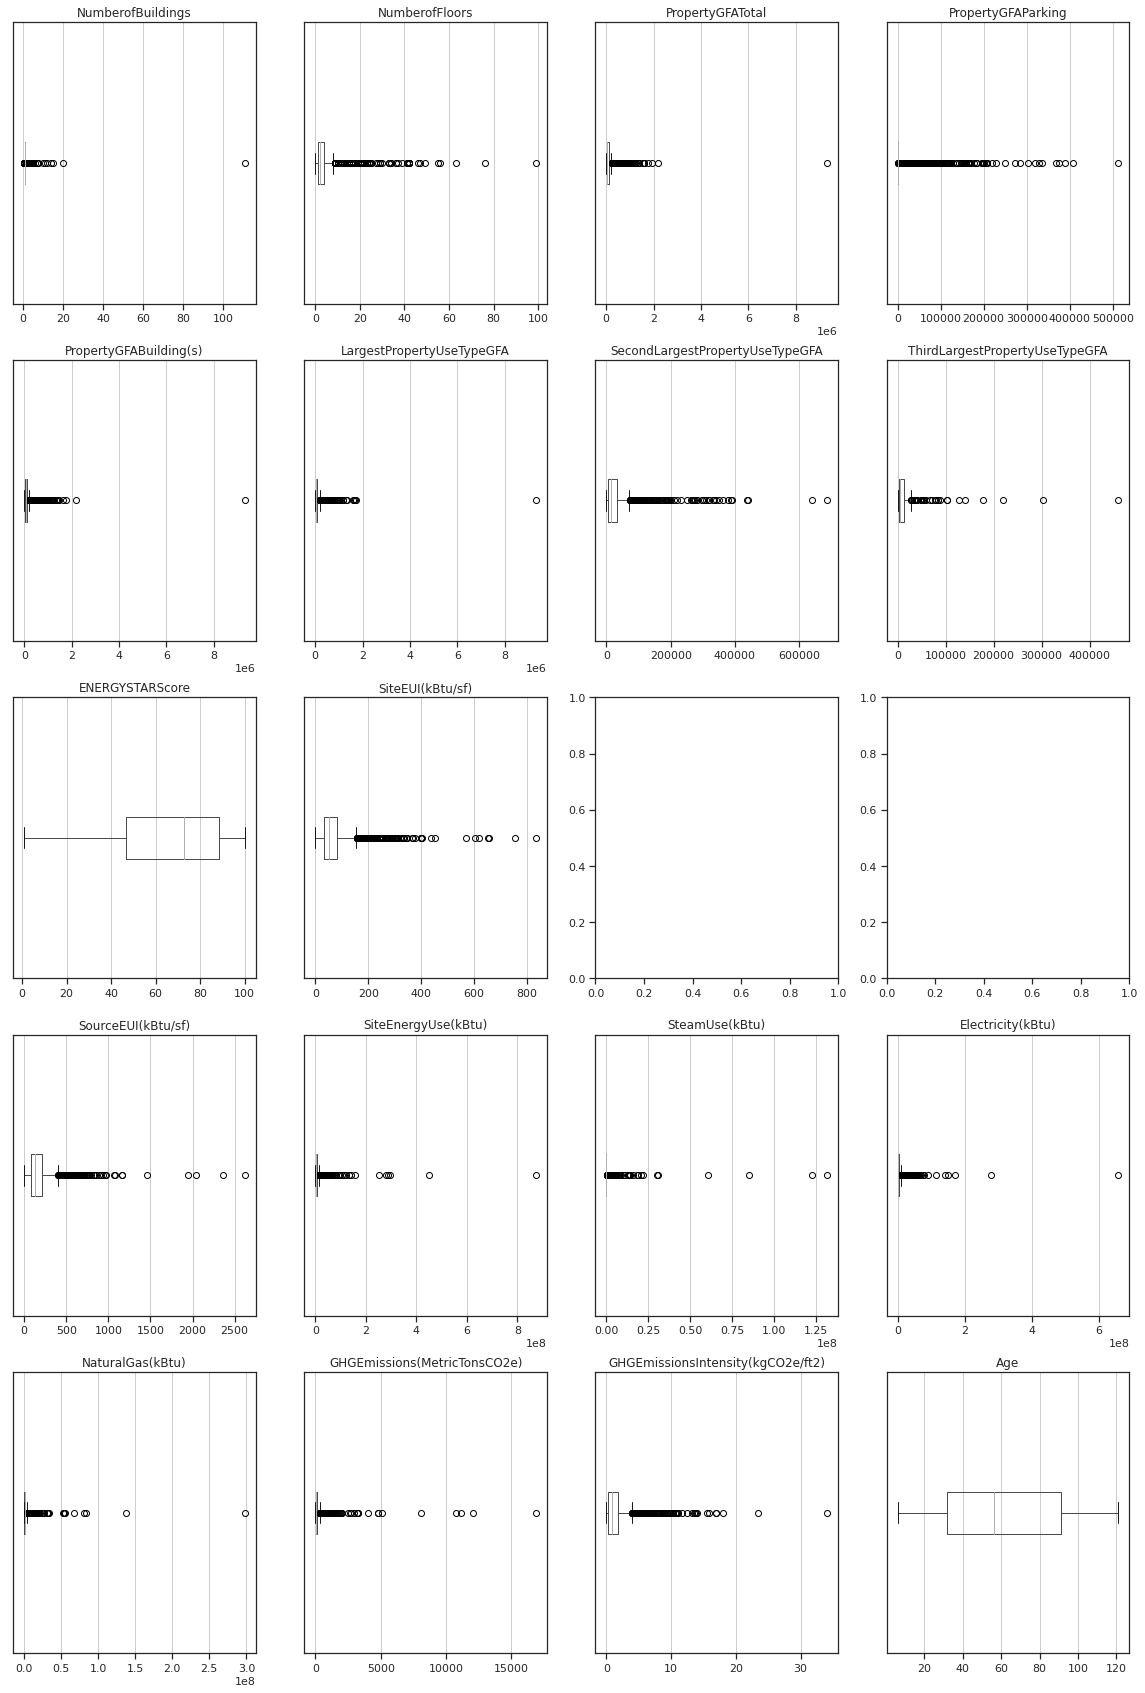

<Figure size 1440x2160 with 0 Axes>

In [749]:
plt.rcParams['figure.figsize'] = (20, 30)
figure, axes = plt.subplots(5, 4)

#Observation avant suppression 
ax1 = data[["NumberofBuildings"]].boxplot(ax=axes[0,0],column="NumberofBuildings", vert=False)
ax1.set_title("NumberofBuildings")
ax2 = data[["NumberofFloors"]].boxplot(ax=axes[0,1],column="NumberofFloors", vert=False)
ax2.set_title("NumberofFloors")
ax3 = data[["PropertyGFATotal"]].boxplot(ax=axes[0,2],column="PropertyGFATotal", vert=False)
ax3.set_title("PropertyGFATotal")
ax4 = data[["PropertyGFAParking"]].boxplot(ax=axes[0,3],column="PropertyGFAParking",vert=False)
ax4.set_title("PropertyGFAParking")
ax5 = data[["PropertyGFABuilding(s)"]].boxplot(ax=axes[1,0],column="PropertyGFABuilding(s)", vert=False)
ax5.set_title("PropertyGFABuilding(s)")
ax6 = data[["LargestPropertyUseTypeGFA"]].boxplot(ax=axes[1,1],column="LargestPropertyUseTypeGFA", vert=False)
ax6.set_title("LargestPropertyUseTypeGFA")
ax7= data[["SecondLargestPropertyUseTypeGFA"]].boxplot(ax=axes[1,2],column="SecondLargestPropertyUseTypeGFA", vert=False)
ax7.set_title("SecondLargestPropertyUseTypeGFA")
ax8= data[["ThirdLargestPropertyUseTypeGFA"]].boxplot(ax=axes[1,3],column="ThirdLargestPropertyUseTypeGFA",vert=False)
ax8.set_title("ThirdLargestPropertyUseTypeGFA")
ax9 = data[["ENERGYSTARScore"]].boxplot(ax=axes[2,0],column="ENERGYSTARScore", vert=False)
ax9.set_title("ENERGYSTARScore")
ax10 = data[["SiteEUI(kBtu/sf)"]].boxplot(ax=axes[2,1],column="SiteEUI(kBtu/sf)", vert=False)
ax10.set_title("SiteEUI(kBtu/sf)")
ax11 = data[["SourceEUI(kBtu/sf)"]].boxplot(ax=axes[3,0],column="SourceEUI(kBtu/sf)", vert=False)
ax11.set_title("SourceEUI(kBtu/sf)")
ax12 = data[["SiteEnergyUse(kBtu)"]].boxplot(ax=axes[3,1],column="SiteEnergyUse(kBtu)", vert=False)
ax12.set_title("SiteEnergyUse(kBtu)")
ax13 = data[["SteamUse(kBtu)"]].boxplot(ax=axes[3,2],column="SteamUse(kBtu)", vert=False)
ax13.set_title("SteamUse(kBtu)")
ax14 = data[["Electricity(kBtu)"]].boxplot(ax=axes[3,3],column="Electricity(kBtu)", vert=False)
ax14.set_title("Electricity(kBtu)")
ax15 = data[["NaturalGas(kBtu)"]].boxplot(ax=axes[4,0],column="NaturalGas(kBtu)", vert=False)
ax15.set_title("NaturalGas(kBtu)")
ax16 = data[["GHGEmissions(MetricTonsCO2e)"]].boxplot(ax=axes[4,1],column="GHGEmissions(MetricTonsCO2e)", vert=False)
ax16.set_title("GHGEmissions(MetricTonsCO2e)")
ax17= data[["GHGEmissionsIntensity(kgCO2e/ft2)"]].boxplot(ax=axes[4,2],column="GHGEmissionsIntensity(kgCO2e/ft2)", vert=False)
ax17.set_title("GHGEmissionsIntensity(kgCO2e/ft2)")
ax18= data[["Age"]].boxplot(ax=axes[4,3],column="Age",vert=False)
ax18.set_title("Age")

for axes in (ax1, ax2, ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12,ax13,ax14,ax15,ax16,ax17,ax18):
    axes.yaxis.set_visible(False)

plt.figure();

Il y a des **outliers** représentées par un cercle dans toutes les colonnes hormis pour "ENERGYSTARScore","Age".

Text(0.5, 1.0, 'NumberofFloors')

<Figure size 1440x2160 with 0 Axes>

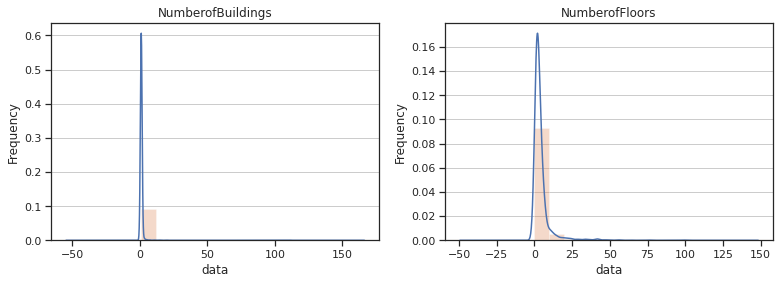

In [750]:
fig = plt.figure()
fig = plt.figure(figsize=(20, 4))

# Create subplot axes
ax1 = fig.add_subplot(1, 3, 1)  # 1x3 grid, position 1
ax2 = fig.add_subplot(1, 3, 2)  # 1x3 grid, position 1



#df2 = pd.DataFrame({'2015': data[data.DataYear == '2015-01-01']["PropertyGFATotal"],
                    #'2016': data[data.DataYear == '2016-01-01']["PropertyGFATotal"]})
ax1 = data["NumberofBuildings"].plot.kde(ax=ax1, legend=False, title='Histogram: 2015 vs. 2016 pour PropertyGFATotal')
ax1 = data["NumberofBuildings"].plot.hist(density=True,stacked=False,alpha=0.3, ax=ax1)

ax2 = data["NumberofFloors"].plot.kde(ax=ax2, legend=False, title='Histogram: 2015 vs. 2016 pour PropertyGFAParking')
ax2 = data["NumberofFloors"].plot.hist(density=True,stacked=False,alpha=0.3, ax=ax2)



# Set first axis y-label
#ax1.set_ylabel('count')
# Set second, third axes y-labels
#for axis in (ax2, ax3):
    #axis.set_ylabel('Probability')

# Set all axes x-labels
for axis in (ax1, ax2):
    axis.set_xlabel('data')    

for axis in (ax1, ax2):
    axis.grid(axis='y')
# Set axis titles
ax1.set_title('NumberofBuildings')
ax2.set_title('NumberofFloors')


Text(0.5, 1.0, 'PropertyGFABuilding(s)')

<Figure size 1440x2160 with 0 Axes>

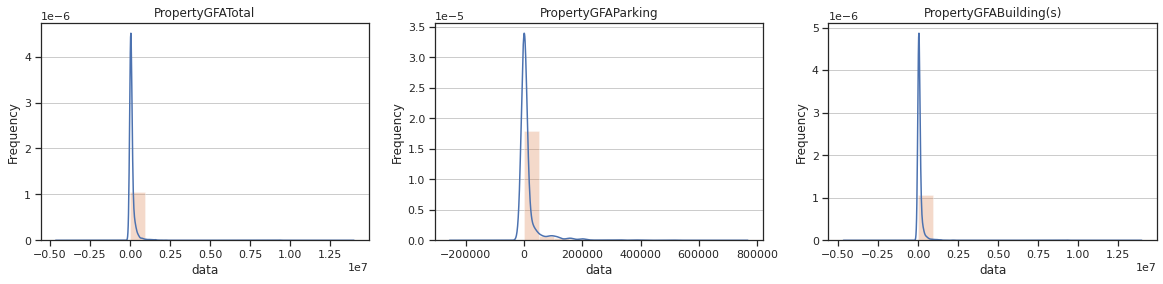

In [751]:
fig = plt.figure()
fig = plt.figure(figsize=(20, 4))

# Create subplot axes
ax1 = fig.add_subplot(1, 3, 1)  # 1x3 grid, position 1
ax2 = fig.add_subplot(1, 3, 2)  # 1x3 grid, position 1
ax3 = fig.add_subplot(1, 3, 3)  # 1x3 grid, position 1


#df2 = pd.DataFrame({'2015': data[data.DataYear == '2015-01-01']["PropertyGFATotal"],
                    #'2016': data[data.DataYear == '2016-01-01']["PropertyGFATotal"]})
ax1 = data["PropertyGFATotal"].plot.kde(ax=ax1, legend=False, title='Histogram: 2015 vs. 2016 pour PropertyGFATotal')
ax1 = data["PropertyGFATotal"].plot.hist(density=True,stacked=False,alpha=0.3, ax=ax1)

ax2 = data["PropertyGFAParking"].plot.kde(ax=ax2, legend=False, title='Histogram: 2015 vs. 2016 pour PropertyGFAParking')
ax2 = data["PropertyGFAParking"].plot.hist(density=True,stacked=False,alpha=0.3, ax=ax2)

ax3 = data["PropertyGFABuilding(s)"].plot.kde(ax=ax3, legend=False, title='Histogram: 2015 vs. 2016 pour PropertyGFABuilding(s)')
ax3 = data["PropertyGFABuilding(s)"].plot.hist(density=True, stacked=False,alpha=0.3,ax=ax3)



# Set first axis y-label
#ax1.set_ylabel('count')
# Set second, third axes y-labels
#for axis in (ax2, ax3):
    #axis.set_ylabel('Probability')

# Set all axes x-labels
for axis in (ax1, ax2, ax3):
    axis.set_xlabel('data')    

for axis in (ax1, ax2, ax3):
    axis.grid(axis='y')
# Set axis titles
ax1.set_title('PropertyGFATotal')
ax2.set_title('PropertyGFAParking')
ax3.set_title('PropertyGFABuilding(s)')


Text(0.5, 1.0, 'ThirdLargestPropertyUseTypeGFA(s)')

<Figure size 1440x2160 with 0 Axes>

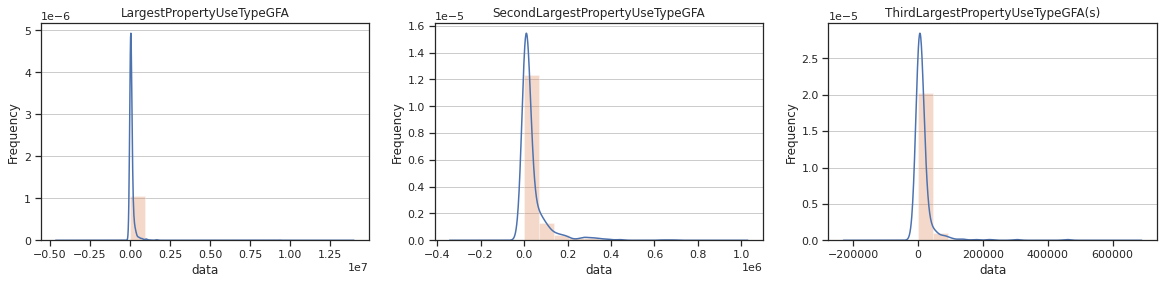

In [752]:
fig = plt.figure()
fig = plt.figure(figsize=(20, 4))

# Create subplot axes
ax1 = fig.add_subplot(1, 3, 1)  # 1x3 grid, position 1
ax2 = fig.add_subplot(1, 3, 2)  # 1x3 grid, position 1
ax3 = fig.add_subplot(1, 3, 3)  # 1x3 grid, position 1


#df2 = pd.DataFrame({'2015': data[data.DataYear == '2015-01-01']["PropertyGFATotal"],
                    #'2016': data[data.DataYear == '2016-01-01']["PropertyGFATotal"]})
ax1 = data["LargestPropertyUseTypeGFA"].plot.kde(ax=ax1, legend=False, title='Histogram: 2015 vs. 2016 pour PropertyGFATotal')
ax1 = data["LargestPropertyUseTypeGFA"].plot.hist(density=True,stacked=False,alpha=0.3, ax=ax1)

ax2 = data["SecondLargestPropertyUseTypeGFA"].plot.kde(ax=ax2, legend=False, title='Histogram: 2015 vs. 2016 pour PropertyGFAParking')
ax2 = data["SecondLargestPropertyUseTypeGFA"].plot.hist(density=True,stacked=False,alpha=0.3, ax=ax2)

ax3 = data["ThirdLargestPropertyUseTypeGFA"].plot.kde(ax=ax3, legend=False, title='Histogram: 2015 vs. 2016 pour PropertyGFABuilding(s)')
ax3 = data["ThirdLargestPropertyUseTypeGFA"].plot.hist(density=True, stacked=False,alpha=0.3,ax=ax3)



# Set first axis y-label
#ax1.set_ylabel('count')
# Set second, third axes y-labels
#for axis in (ax2, ax3):
    #axis.set_ylabel('Probability')

# Set all axes x-labels
for axis in (ax1, ax2, ax3):
    axis.set_xlabel('data')    

for axis in (ax1, ax2, ax3):
    axis.grid(axis='y')
# Set axis titles
ax1.set_title('LargestPropertyUseTypeGFA')
ax2.set_title('SecondLargestPropertyUseTypeGFA')
ax3.set_title('ThirdLargestPropertyUseTypeGFA(s)')


Text(0.5, 1.0, 'SteamUse(kBtu)')

<Figure size 1440x2160 with 0 Axes>

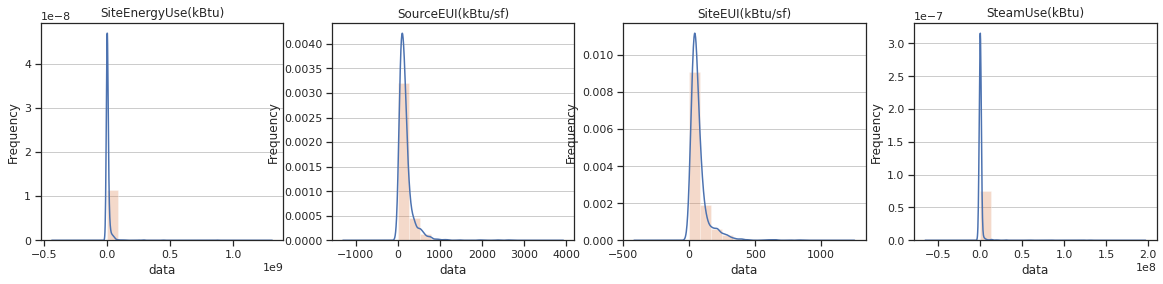

In [753]:
fig = plt.figure()
fig = plt.figure(figsize=(20, 4))

# Create subplot axes
ax1 = fig.add_subplot(1, 4, 1)  # 1x3 grid, position 1
ax2 = fig.add_subplot(1, 4, 2)  # 1x3 grid, position 1
ax3 = fig.add_subplot(1, 4, 3)  # 1x3 grid, position 1
ax4 = fig.add_subplot(1, 4, 4) 


ax1 = data["SiteEnergyUse(kBtu)"].plot.kde(ax=ax1, legend=False, title='Histogram: 2015 vs. 2016 pour SiteEnergyUse(kBtu)')
ax1 = data["SiteEnergyUse(kBtu)"].plot.hist(density=True,stacked=False,alpha=0.3, ax=ax1)

ax2 = data["SourceEUI(kBtu/sf)"].plot.kde(ax=ax2, legend=False, title='Histogram: 2015 vs. 2016 pour SourceEUI(kBtu/sf)')
ax2 = data["SourceEUI(kBtu/sf)"].plot.hist(density=True,stacked=False,alpha=0.3, ax=ax2)

ax3 = data["SiteEUI(kBtu/sf)"].plot.kde(ax=ax3, legend=False, title='Histogram: 2015 vs. 2016 pour SiteEUI(kBtu/sf)')
ax3 = data["SiteEUI(kBtu/sf)"].plot.hist(density=True, stacked=False,alpha=0.3,ax=ax3)

ax4 = data["SteamUse(kBtu)"].plot.kde(ax=ax4, legend=False, title='Histogram: 2015 vs. 2016 pour SteamUse(kBtu)')
ax4 = data["SteamUse(kBtu)"].plot.hist(density=True, stacked=False,alpha=0.3,ax=ax4)


# Set first axis y-label
#ax1.set_ylabel('count')
# Set second, third axes y-labels
#for axis in (ax2, ax3):
    #axis.set_ylabel('Probability')

# Set all axes x-labels
for axis in (ax1, ax2, ax3,ax4):
    axis.set_xlabel('data')    

for axis in (ax1, ax2, ax3,ax4):
    axis.grid(axis='y')
# Set axis titles
ax1.set_title('SiteEnergyUse(kBtu)')
ax2.set_title('SourceEUI(kBtu/sf)')
ax3.set_title('SiteEUI(kBtu/sf)')
ax4.set_title('SteamUse(kBtu)')

Text(0.5, 1.0, 'GHGEmissionsIntensity(kgCO2e/ft2)')

<Figure size 1440x2160 with 0 Axes>

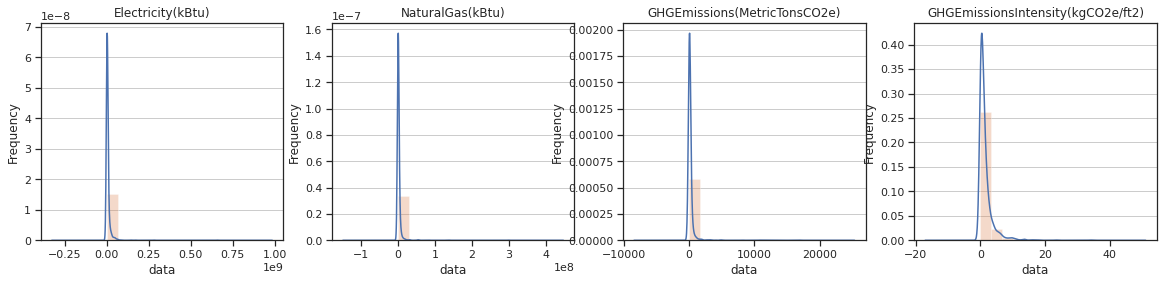

In [754]:
fig = plt.figure()
fig = plt.figure(figsize=(20, 4))

# Create subplot axes
ax1 = fig.add_subplot(1, 4, 1)  # 1x3 grid, position 1
ax2 = fig.add_subplot(1, 4, 2)  # 1x3 grid, position 1
ax3 = fig.add_subplot(1, 4, 3)  # 1x3 grid, position 1
ax4 = fig.add_subplot(1, 4, 4) 


ax1 = data["Electricity(kBtu)"].plot.kde(ax=ax1, legend=False, title='Histogram: 2015 vs. 2016 pour Electricity(kBtu)')
ax1 = data["Electricity(kBtu)"].plot.hist(density=True,stacked=False,alpha=0.3, ax=ax1)

ax2 = data["NaturalGas(kBtu)"].plot.kde(ax=ax2, legend=False, title='Histogram: 2015 vs. 2016 pour NaturalGas(kBtu)')
ax2 = data["NaturalGas(kBtu)"].plot.hist(density=True,stacked=False,alpha=0.3, ax=ax2)

ax3 = data["GHGEmissions(MetricTonsCO2e)"].plot.kde(ax=ax3, legend=False, title='Histogram: 2015 vs. 2016 pour GHGEmissions(MetricTonsCO2e)')
ax3 = data["GHGEmissions(MetricTonsCO2e)"].plot.hist(density=True, stacked=False,alpha=0.3,ax=ax3)

ax4 = data["GHGEmissionsIntensity(kgCO2e/ft2)"].plot.kde(ax=ax4, legend=False, title='Histogram: 2015 vs. 2016 pour GHGEmissionsIntensity(kgCO2e/ft2)')
ax4 = data["GHGEmissionsIntensity(kgCO2e/ft2)"].plot.hist(density=True, stacked=False,alpha=0.3,ax=ax4)


# Set first axis y-label
#ax1.set_ylabel('count')
# Set second, third axes y-labels
#for axis in (ax2, ax3):
    #axis.set_ylabel('Probability')

# Set all axes x-labels
for axis in (ax1, ax2, ax3,ax4):
    axis.set_xlabel('data')    

for axis in (ax1, ax2, ax3,ax4):
    axis.grid(axis='y')
# Set axis titles
ax1.set_title('Electricity(kBtu)')
ax2.set_title('NaturalGas(kBtu)')
ax3.set_title('GHGEmissions(MetricTonsCO2e)')
ax4.set_title('GHGEmissionsIntensity(kgCO2e/ft2)')

Text(0.5, 1.0, 'Age')

<Figure size 1440x2160 with 0 Axes>

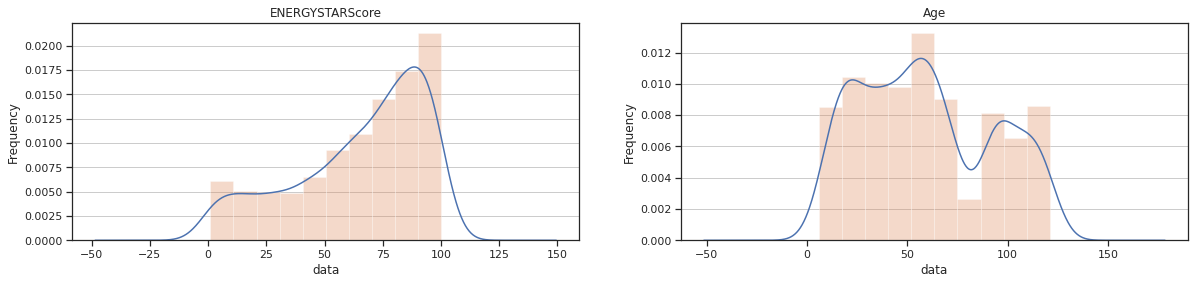

In [755]:
fig = plt.figure()
fig = plt.figure(figsize=(20, 4))

# Create subplot axes
ax1 = fig.add_subplot(1, 2, 1)  # 1x3 grid, position 1
ax2 = fig.add_subplot(1, 2, 2)  # 1x3 grid, position 1


ax1 = data["ENERGYSTARScore"].plot.kde(ax=ax1, legend=False, title='Histogram: 2015 vs. 2016 pour ENERGYSTARScore')
ax1 = data["ENERGYSTARScore"].plot.hist(density=True,stacked=False,alpha=0.3, ax=ax1)

ax2 = data["Age"].plot.kde(ax=ax2, legend=False, title='Histogram: 2015 vs. 2016 pour Age')
ax2 = data["Age"].plot.hist(density=True,stacked=False,alpha=0.3, ax=ax2)

# Set all axes x-labels
for axis in (ax1, ax2):
    axis.set_xlabel('data')    

for axis in (ax1, ax2):
    axis.grid(axis='y')
# Set axis titles
ax1.set_title('ENERGYSTARScore')
ax2.set_title('Age')


Si on regarde les graphiques ci-dessous les queues de distribution ne sont pas lourdes.

Donc, pour la colonne "Outlier", soit il s'agit d'erreurs - soit de valeurs atypiques. Essayons de ploter les valeurs de la **colonne Outlier**.

In [799]:
data.Outlier = data.Outlier.replace(np.nan , 'No outlier' , inplace=False)
data["Outlier"].unique()

array(['No outlier', 'Low outlier', 'High outlier'], dtype=object)

In [800]:
import numpy 
import pandas
from  matplotlib import pyplot
import seaborn 
seaborn.set(style='ticks')

#Emission de Co2 en fonction de la surface totale
numpy.random.seed(0)
N = 1695
_outlier= ['No outlier', 'Low outlier', 'High outlier']

In [801]:
long_df = data[["NumberofBuildings","NumberofFloors",
                 "PropertyGFATotal","PropertyGFAParking","PropertyGFABuilding(s)",
                 "LargestPropertyUseTypeGFA","SecondLargestPropertyUseTypeGFA","ThirdLargestPropertyUseTypeGFA",
                 "ENERGYSTARScore",
                 "SiteEUI(kBtu/sf)","SourceEUI(kBtu/sf)","SiteEnergyUse(kBtu)",
                 "SteamUse(kBtu)","Electricity(kBtu)","NaturalGas(kBtu)","GHGEmissions(MetricTonsCO2e)",
                 "GHGEmissionsIntensity(kgCO2e/ft2)","Age","Outlier"]]
long_df.head()

,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),Age,Outlier
0,1.0,4.0,111077.0,0.0,111077.0,NaN,NaN,NaN,91.0,60.6,190.2,9898724.0,0.0,9899135.0,0.0,69.01,0.24,32,No outlier
1,1.0,6.0,98370.0,25920.0,72450.0,98370.0,NaN,NaN,45.0,66.3,207.5,6525887.0,0.0,6488262.0,37893.0,47.24,0.20,115,No outlier
2,1.0,4.0,193788.0,37854.0,155934.0,138672.0,47539.0,11166.0,59.0,105.8,332.3,16760217.0,0.0,16760914.0,0.0,116.84,0.23,74,No outlier
3,1.0,3.0,76598.0,21410.0,55188.0,55188.0,21410.0,NaN,76.0,81.1,169.8,4476997.0,0.0,2234200.0,2242889.0,134.69,1.63,13,No outlier
4,1.0,4.0,186971.0,0.0,186971.0,186977.0,115477.0,NaN,86.0,67.7,179.1,12662456.0,0.0,9657951.0,3004906.0,226.92,0.99,40,No outlier


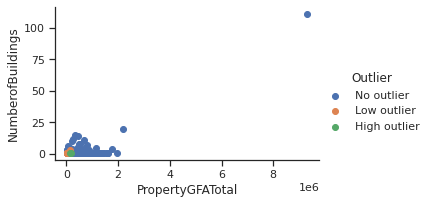

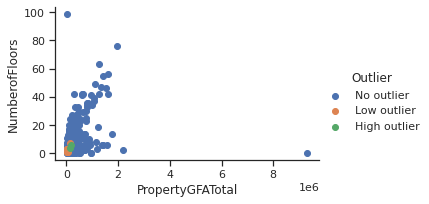

In [759]:
df = data[["PropertyGFATotal","NumberofBuildings","Outlier"]]
fg = sns.FacetGrid(data=df, hue='Outlier', hue_order=_outlier, aspect=1.61)
fg.map(pyplot.scatter, 'PropertyGFATotal', 'NumberofBuildings').add_legend()

df = data[["PropertyGFATotal","NumberofFloors","Outlier"]]
fg =sns.FacetGrid(data=df, hue='Outlier', hue_order=_outlier, aspect=1.61)
fg.map(pyplot.scatter, 'PropertyGFATotal', 'NumberofFloors').add_legend()

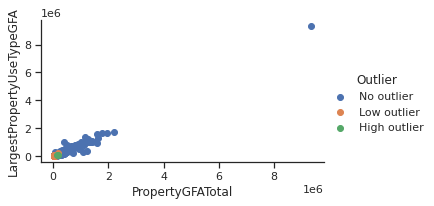

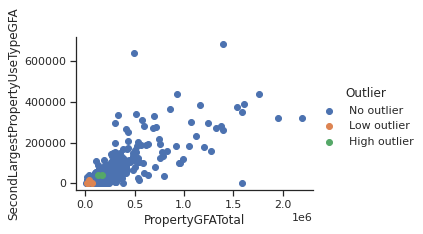

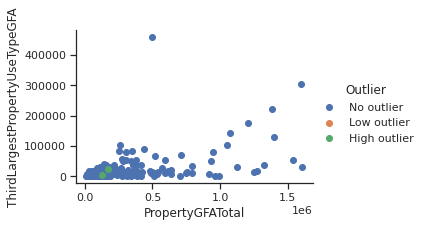

In [762]:
df = data[["PropertyGFATotal","LargestPropertyUseTypeGFA","Outlier"]]
fg = seaborn.FacetGrid(data=df, hue='Outlier', hue_order=_outlier, aspect=1.61)
fg.map(pyplot.scatter, 'PropertyGFATotal', 'LargestPropertyUseTypeGFA').add_legend()

df = data[["PropertyGFATotal","SecondLargestPropertyUseTypeGFA","Outlier"]]
fg = seaborn.FacetGrid(data=df, hue='Outlier', hue_order=_outlier, aspect=1.61)
fg.map(pyplot.scatter, 'PropertyGFATotal', 'SecondLargestPropertyUseTypeGFA').add_legend()

df = data[["PropertyGFATotal","ThirdLargestPropertyUseTypeGFA","Outlier"]]
fg = seaborn.FacetGrid(data=df, hue='Outlier', hue_order=_outlier, aspect=1.61)
fg.map(pyplot.scatter, 'PropertyGFATotal', 'ThirdLargestPropertyUseTypeGFA').add_legend()

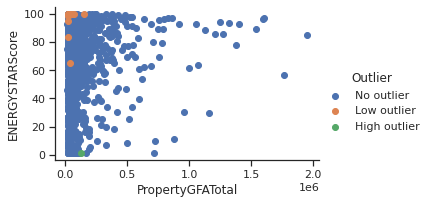

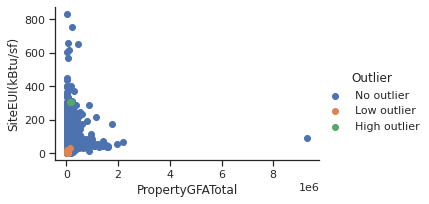

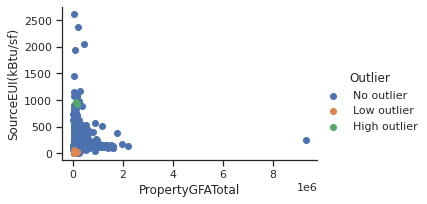

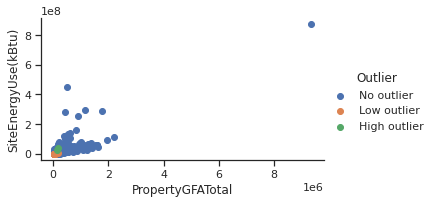

In [763]:

df = data[["PropertyGFATotal","ENERGYSTARScore","Outlier"]]
fg = seaborn.FacetGrid(data=df, hue='Outlier', hue_order=_outlier, aspect=1.61)
fg.map(pyplot.scatter, 'PropertyGFATotal', 'ENERGYSTARScore').add_legend()

df = data[["PropertyGFATotal","SiteEUI(kBtu/sf)","Outlier"]]
fg = seaborn.FacetGrid(data=df, hue='Outlier', hue_order=_outlier, aspect=1.61)
fg.map(pyplot.scatter, 'PropertyGFATotal', 'SiteEUI(kBtu/sf)').add_legend()

df = data[["PropertyGFATotal","SourceEUI(kBtu/sf)","Outlier"]]
fg = seaborn.FacetGrid(data=df, hue='Outlier', hue_order=_outlier, aspect=1.61)
fg.map(pyplot.scatter, 'PropertyGFATotal', 'SourceEUI(kBtu/sf)').add_legend()

df = data[["PropertyGFATotal","SiteEnergyUse(kBtu)","Outlier"]]
fg = seaborn.FacetGrid(data=df, hue='Outlier', hue_order=_outlier, aspect=1.61)
fg.map(pyplot.scatter, 'PropertyGFATotal', 'SiteEnergyUse(kBtu)').add_legend()

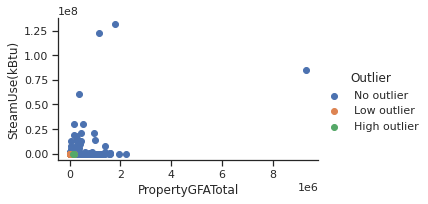

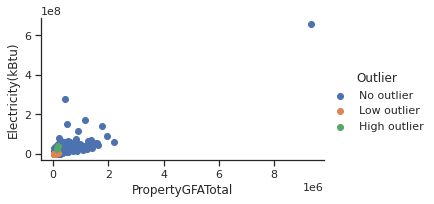

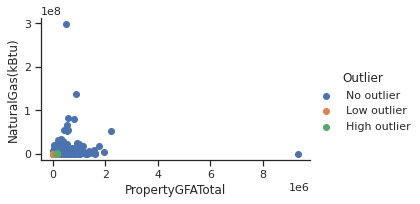

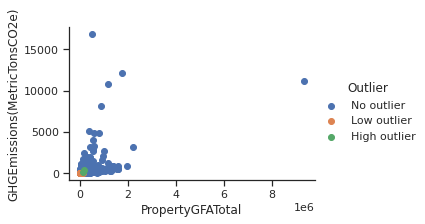

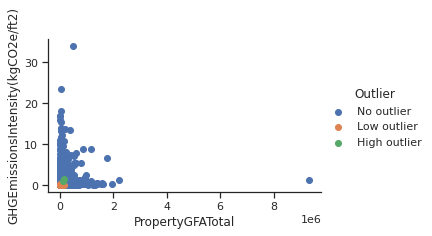

In [764]:

df = data[["PropertyGFATotal","SteamUse(kBtu)","Outlier"]]
fg = seaborn.FacetGrid(data=df, hue='Outlier', hue_order=_outlier, aspect=1.61)
fg.map(pyplot.scatter, 'PropertyGFATotal', 'SteamUse(kBtu)').add_legend()

df = data[["PropertyGFATotal","Electricity(kBtu)","Outlier"]]
fg = seaborn.FacetGrid(data=df, hue='Outlier', hue_order=_outlier, aspect=1.61)
fg.map(pyplot.scatter, 'PropertyGFATotal', 'Electricity(kBtu)').add_legend()

df = data[["PropertyGFATotal","NaturalGas(kBtu)","Outlier"]]
fg = seaborn.FacetGrid(data=df, hue='Outlier', hue_order=_outlier, aspect=1.61)
fg.map(pyplot.scatter, 'PropertyGFATotal', 'NaturalGas(kBtu)').add_legend()

df = data[["PropertyGFATotal","GHGEmissions(MetricTonsCO2e)","Outlier"]]
fg = seaborn.FacetGrid(data=df, hue='Outlier', hue_order=_outlier, aspect=1.61)
fg.map(pyplot.scatter, 'PropertyGFATotal', 'GHGEmissions(MetricTonsCO2e)').add_legend()

df = data[["PropertyGFATotal","GHGEmissionsIntensity(kgCO2e/ft2)","Outlier"]]
fg = seaborn.FacetGrid(data=df, hue='Outlier', hue_order=_outlier, aspect=1.61)
fg.map(pyplot.scatter, 'PropertyGFATotal', 'GHGEmissionsIntensity(kgCO2e/ft2)').add_legend()

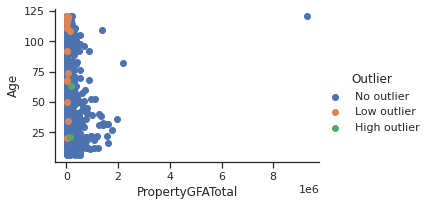

In [765]:
df = data[["PropertyGFATotal","Age","Outlier"]]
fg = seaborn.FacetGrid(data=df, hue='Outlier', hue_order=_outlier, aspect=1.61)
fg.map(pyplot.scatter, 'PropertyGFATotal', 'Age').add_legend()

En observant les graphiques ci-dessus, on constate que la colonne Outlier ne reflète pas les Outliers. \
Donc nous allons conserver les valeurs de la colonnes Outlier. 



Ce qu'on observe par contre, c'est 5 points en haut du nuage de points plus éloignés, et  un point extrêment éloigné. S'agit il d'une erreur ou bien d'une valeur réelle ?  

Pour les points faiblements éloignés, je penche pour des valeurs atypiques que l'on va supprimer par la méthode interquartile. Je choisis de les supprimer car sinon les données sont trop dispersées pouvant fausser les résultats. cf apres Imputation des NaN.
Et pour l'unique point extrêment éloigné, je penche pour une valeur aberrante qu'il faut supprimer.



In [802]:
data = data.loc[data['Electricity(kBtu)']!=data['Electricity(kBtu)'].max()]
data.shape

(1694, 41)

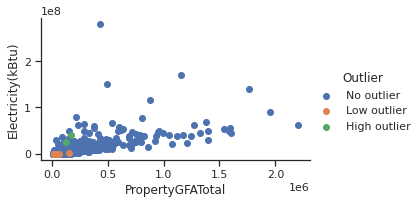

In [803]:
#Vérification

seaborn.set(style='ticks')

numpy.random.seed(0)
N = 1695
_outlier= ['No outlier', 'Low outlier', 'High outlier']
df = data[["PropertyGFATotal","Electricity(kBtu)","Outlier"]]
   

fg = seaborn.FacetGrid(data=df, hue='Outlier', hue_order=_outlier, aspect=1.61)
fg.map(pyplot.scatter, 'PropertyGFATotal', 'Electricity(kBtu)').add_legend()

Nous allons pour le moment conserver les autres variables en l'état. Une courte analyse exploratoire nous en apprendra plus sur les données à conserver.

In [804]:
data.to_csv("2015_2016_building_energy_benchmarking_avt_exploration",sep =",",index=False)

# <font color="#1d479b" id="section_2">Analyse exploratoire & Feature Engineering</font>



In [805]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ignores any warning
import warnings 
import ast
import scipy.stats as st

warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (7, 5) #(L,l)

pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [834]:
data = pd.read_csv("2015_2016_building_energy_benchmarking_avt_exploration",sep ="," ,dtype={'ZipCode':str}) 
print(data.shape)

#Retypage apres le chargement du csv
#data["YearBuilt"] = data["YearBuilt"].astype('datetime64[ns]')
data["DataYear"] = data["DataYear"].astype('datetime64[ns]')
data["OSEBuildingID"] = data["OSEBuildingID"].astype('object')
data["CouncilDistrictCode"] = data["CouncilDistrictCode"].astype('object')
data["ZipCode"] = data["ZipCode"].astype('object')

(1694, 41)


## <font color="#337da4" id="section_2">Variables catégoriques</font>

In [835]:
categorical_features = data.select_dtypes(exclude=['int64','float64']) 
categorical_features.describe(include="object").transpose()

,count,unique,top,freq
OSEBuildingID,1694,1694,20474,1
BuildingType,1694,5,NonResidential,1487
PrimaryPropertyType,1694,23,Small- and Mid-Sized Office,299
PropertyName,1694,1690,Airport Way,2
TaxParcelIdentificationNumber,1694,1613,1625049001,7
CouncilDistrictCode,1694,7,7,542
Neighborhood,1694,19,DOWNTOWN,369
ListOfAllPropertyUseTypes,1685,375,Office,144
LargestPropertyUseType,1681,57,Office,507
SecondLargestPropertyUseType,864,47,Parking,343


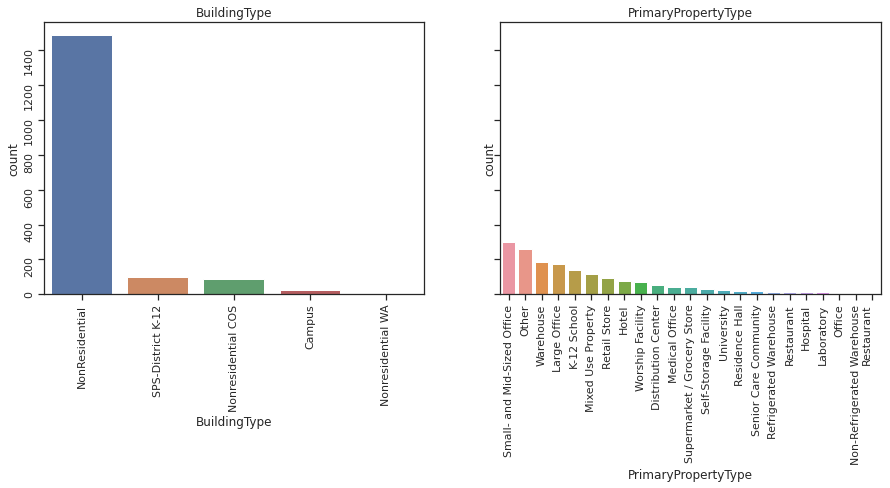

In [824]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
#fig.suptitle('BuildingType - LargestPropertyUseType - PrimaryPropertyType')



sns.countplot(x="BuildingType",data=data,ax=axes[0],order = data['BuildingType'].value_counts().index,orient="h")
axes[0].set_title("BuildingType")
axes[0].tick_params(labelrotation=90)

sns.countplot(x="PrimaryPropertyType",data=data, ax=axes[1], order = data['PrimaryPropertyType'].value_counts().index, orient="h")
axes[1].set_title("PrimaryPropertyType")
axes[1].tick_params(labelrotation=90)

La majeur partie des bâtiments sont typés "NonResidential". Nous pouvons visualiser les diverses catégories représentées dans ce type de bâtiments :

In [825]:
data.loc[(data['BuildingType']=="NonResidential"),'PrimaryPropertyType'].value_counts()

Small- and Mid-Sized Office    295
Other                          191
Warehouse                      180
Large Office                   171
Mixed Use Property             104
Retail Store                    94
Hotel                           76
Worship Facility                72
Distribution Center             51
Medical Office                  41
K-12 School                     40
Supermarket / Grocery Store     40
Self-Storage Facility           28
Residence Hall                  21
Senior Care Community           20
University                      17
Refrigerated Warehouse          12
Restaurant                      11
Hospital                        10
Laboratory                      10
Non-Refrigerated Warehouse       2
Restaurant\n                     1
Name: PrimaryPropertyType, dtype: int64

Ici, on remarque que des catégories sont des doublons avec un caractère d'échappement. Nous allons corriger ce problème :

In [826]:
import re
regex = re.compile(r'[\n\r\t]')
data['PrimaryPropertyType'] = [regex.sub("", item) for index, item in data.PrimaryPropertyType.iteritems()]
data.loc[(data['BuildingType']=="NonResidential"),'PrimaryPropertyType'].value_counts()

Small- and Mid-Sized Office    295
Other                          191
Warehouse                      180
Large Office                   171
Mixed Use Property             104
Retail Store                    94
Hotel                           76
Worship Facility                72
Distribution Center             51
Medical Office                  41
K-12 School                     40
Supermarket / Grocery Store     40
Self-Storage Facility           28
Residence Hall                  21
Senior Care Community           20
University                      17
Refrigerated Warehouse          12
Restaurant                      12
Hospital                        10
Laboratory                      10
Non-Refrigerated Warehouse       2
Name: PrimaryPropertyType, dtype: int64

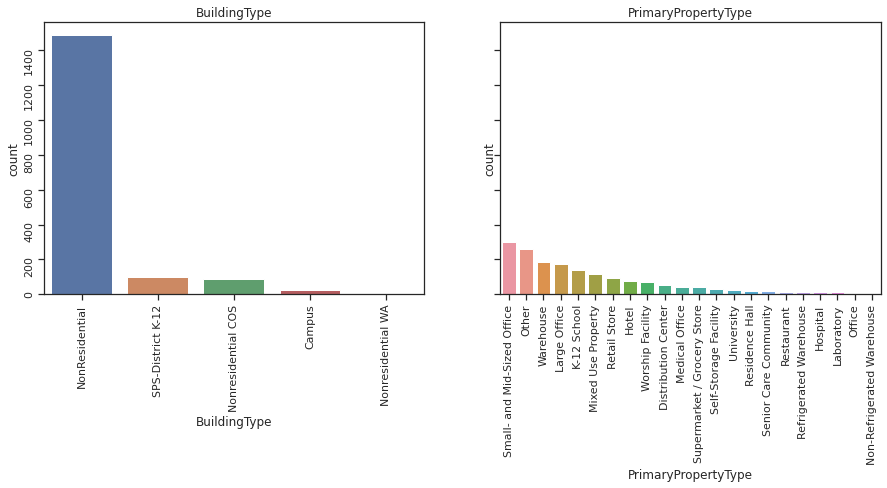

In [827]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
#fig.suptitle('BuildingType - LargestPropertyUseType - PrimaryPropertyType')



sns.countplot(x="BuildingType",data=data,ax=axes[0],order = data['BuildingType'].value_counts().index,orient="h")
axes[0].set_title("BuildingType")
axes[0].tick_params(labelrotation=90)

sns.countplot(x="PrimaryPropertyType",data=data, ax=axes[1], order = data['PrimaryPropertyType'].value_counts().index, orient="h")
axes[1].set_title("PrimaryPropertyType")
axes[1].tick_params(labelrotation=90)

Dans les alentour de 300 - 200, les bâtiments concernent surtout les bureaux, autres ou bien les bâtiments de stockage.

Text(0.5, 1.0, 'Neighborhood')

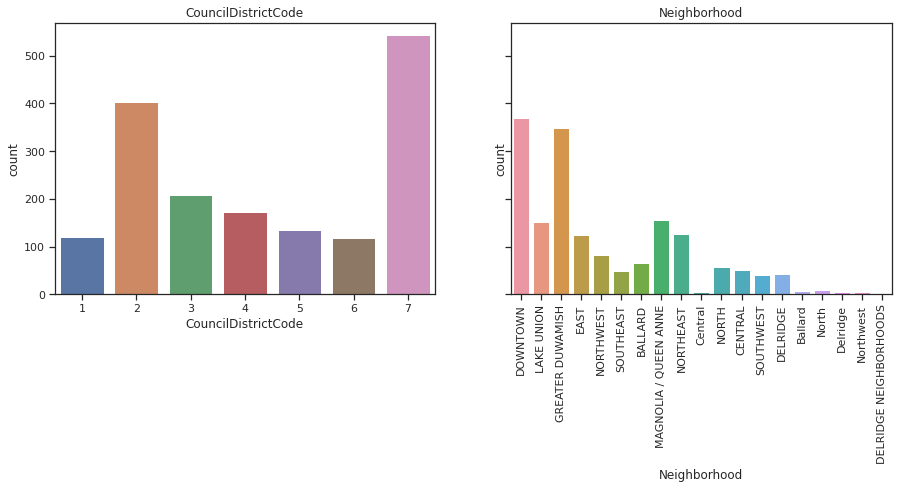

In [828]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", color_codes=True)

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

CouncilDistrictCode = data['CouncilDistrictCode']
Neighborhood = data['Neighborhood']
ZipCode = data['ZipCode']

sns.countplot(data.CouncilDistrictCode,ax=axes[0])
plt.xticks(rotation=90)
axes[0].set_title(CouncilDistrictCode.name)

sns.countplot(data.Neighborhood, ax=axes[1])
plt.xticks(rotation=90)
axes[1].set_title(Neighborhood.name)

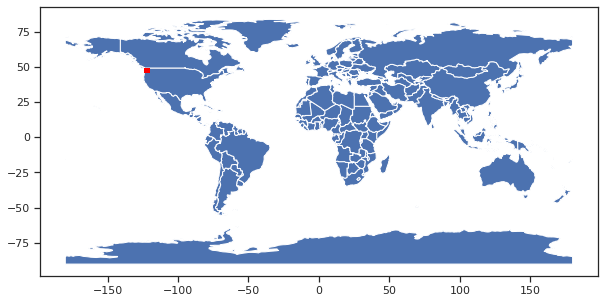

In [829]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame



geometry = [Point(xy) for xy in zip(data['Longitude'], data['Latitude'])]
gdf = GeoDataFrame(data, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);


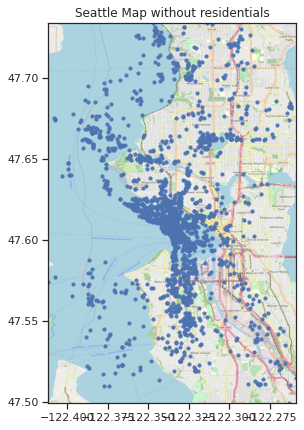

In [814]:
#https://towardsdatascience.com/easy-steps-to-plot-geographic-data-on-a-map-python-11217859a2db
fig, ax = plt.subplots(figsize = (8,7))

BBox = ((data.Longitude.min(),   data.Longitude.max(),      
         data.Latitude.min(), data.Latitude.max()))

ax.scatter(data.Longitude, data.Latitude, zorder=1, alpha= 0.9, c='b', s=10)

ax.set_title('Seattle Map without residentials')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ruh_m = plt.imread('map.png')

ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')

In [815]:
data[data['ZipCode'].isnull() == True]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,YearsENERGYSTARCertified,DefaultData,ComplianceStatus,Outlier,Latitude,Longitude,Address,City,State,ZipCode,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),Age,geometry
1678,50196,2016-01-01,Nonresidential COS,Mixed Use Property,Northgate Community Center,2926049431,5,NORTH,2005,"Fitness Center/Health Club/Gym, Office, Other ...",Other - Recreation,Fitness Center/Health Club/Gym,Pre-school/Daycare,NaN,False,Compliant,No outlier,47.70541,-122.32232,10510 5th Ave NE,Seattle,WA,NaN,1.0,1.0,20616.0,0.0,20616.0,9900.0,8577.0,1364.0,NaN,30.900000,97.000000,6.369655e+05,0.0,6.369655e+05,0.000000e+00,4.44,0.22,16,POINT (-122.32232 47.70541)
1679,50198,2016-01-01,Nonresidential COS,Other,Fire Station 06 (New),1250200565,3,CENTRAL,2013,Prison/Incarceration,Prison/Incarceration,NaN,NaN,NaN,False,Compliant,No outlier,47.59905,-122.29787,405 MLK Jr Way S,Seattle,WA,NaN,1.0,1.0,11685.0,0.0,11685.0,11685.0,NaN,NaN,NaN,72.800003,138.600006,8.510538e+05,0.0,3.472887e+05,5.037650e+05,29.18,2.50,8,POINT (-122.29787 47.59905)
1680,50201,2016-01-01,Nonresidential COS,Other,Fire Station 35 (New),3300700810,6,BALLARD,2010,Prison/Incarceration,Prison/Incarceration,NaN,NaN,NaN,False,Compliant,No outlier,47.69330,-122.37717,8729 15th Ave NW,Seattle,WA,NaN,1.0,1.0,11968.0,0.0,11968.0,11968.0,NaN,NaN,NaN,65.500000,139.199997,7.834230e+05,0.0,4.032431e+05,3.801800e+05,23.00,1.92,11,POINT (-122.37717 47.69330)
1681,50204,2016-01-01,Nonresidential COS,Other,Fire Station 39 (New),3834500066,5,NORTH,1949,Prison/Incarceration,Prison/Incarceration,NaN,NaN,NaN,False,Compliant,No outlier,47.72126,-122.29735,2806 NE 127th St,Seattle,WA,NaN,1.0,1.0,11285.0,0.0,11285.0,11285.0,NaN,NaN,NaN,57.200001,140.000000,6.456654e+05,0.0,4.317954e+05,2.138700e+05,14.37,1.27,72,POINT (-122.29735 47.72126)
1682,50207,2016-01-01,Nonresidential COS,Other,Ballard Community Center,6658000065,6,BALLARD,1911,"Fitness Center/Health Club/Gym, Food Service, ...",Other - Recreation,Fitness Center/Health Club/Gym,Pre-school/Daycare,NaN,False,Compliant,No outlier,47.67295,-122.39228,6020 28th ave NW,Seattle,WA,NaN,1.0,1.0,16795.0,0.0,16795.0,8680.0,7014.0,535.0,NaN,55.799999,126.000000,9.366165e+05,0.0,5.421344e+05,3.944820e+05,24.73,1.47,110,POINT (-122.39228 47.67295)
1683,50208,2016-01-01,Nonresidential COS,Other,Ballard Pool,3050700005,6,BALLARD,1972,"Fitness Center/Health Club/Gym, Office, Other ...",Other - Recreation,Fitness Center/Health Club/Gym,Office,NaN,False,Compliant,No outlier,47.67734,-122.37624,1471 NW 67th St,Seattle,WA,NaN,1.0,1.0,12769.0,0.0,12769.0,10912.0,1670.0,187.0,NaN,400.799988,618.099976,5.117308e+06,0.0,1.205173e+06,3.912135e+06,216.18,16.93,49,POINT (-122.37624 47.67734)
1684,50210,2016-01-01,Nonresidential COS,Office,Central West HQ / Brown Bear,2425039137,7,MAGNOLIA / QUEEN ANNE,1952,Office,Office,NaN,NaN,NaN,True,Error - Correct Default Data,No outlier,47.63572,-122.37525,1403 w howe,Seattle,WA,NaN,1.0,1.0,13661.0,0.0,13661.0,13661.0,NaN,NaN,75.0,36.799999,115.500000,5.026677e+05,0.0,5.026678e+05,0.000000e+00,3.50,0.26,69,POINT (-122.37525 47.63572)
1685,50212,2016-01-01,Nonresidential COS,Other,Conservatory Campus,2925049087,3,EAST,1912,Other - Recreation,Other - Recreation,NaN,NaN,NaN,False,Compliant,No outlier,47.63228,-122.31574,1400 E Galer St,Seattle,WA,NaN,1.0,1.0,23445.0,0.0,23445.0,23445.0,NaN,NaN,NaN,254.899994,380.100006,5.976246e+06,0.0,1.260870e+06,4.715376e+06,259.22,11.06,109,POINT (-122.

In [836]:
L1 = ["98125", 
      "98144",
      "98117",
      "98125", 
      "98107",
      "98117",
      "98119",
      "98112",
      "98122",
      "98118",
      "98126",
      "98108",
      "37203",
      "98119",
      "98108",
      "98108"]
      
                                          
data.loc[data['ZipCode'].isnull(), 'ZipCode'] = L1

In [838]:
data.ZipCode.unique()

array(['98101.0', '98109.0', '98144.0', '98104.0', '98134.0', '98122.0',
       '98103.0', '98133.0', '98118.0', '98102.0', '98107.0', '98121.0',
       '98119.0', '98154.0', '98105.0', '98112.0', '98125.0', '98070.0',
       '98108.0', '98199.0', '98115.0', '98136.0', '98126.0', '98146.0',
       '98033.0', '98106.0', '98111.0', '98117.0', '98116.0', '98191.0',
       '98164.0', '98195.0', '98185.0', '98181.0', '98168.0', '98155.0',
       '98006.0', '98124.0', '98053.0', '98013.0', '98178.0', '98114.0',
       '98165.0', '98011.0', '98113.0', '98177.0', '98020.0', '98145.0',
       '98125', '98144', '98117', '98107', '98119', '98112', '98122',
       '98118', '98126', '98108', '37203'], dtype=object)

In [839]:
data['ZipCode'] = data['ZipCode'].str.slice(0, 5)
data['ZipCode'] 

0       98101
1       98101
2       98109
3       98144
4       98109
5       98109
6       98104
7       98104
8       98134
9       98122
10      98103
11      98101
12      98101
13      98133
14      98133
15      98101
16      98118
17      98102
18      98118
19      98107
20      98107
21      98144
22      98121
23      98119
24      98144
25      98109
26      98104
27      98109
28      98122
29      98119
30      98101
31      98101
32      98101
33      98101
34      98121
35      98101
36      98101
37      98101
38      98104
39      98101
40      98101
41      98104
42      98101
43      98101
44      98154
45      98104
46      98104
47      98104
48      98104
49      98104
50      98104
51      98118
52      98105
53      98121
54      98101
55      98101
56      98101
57      98112
58      98121
59      98125
60      98109
61      98070
62      98105
63      98105
64      98108
65      98118
66      98199
67      98115
68      98107
69      98144
70      98103
71    

Text(0.5, 1.0, 'ZipCode')

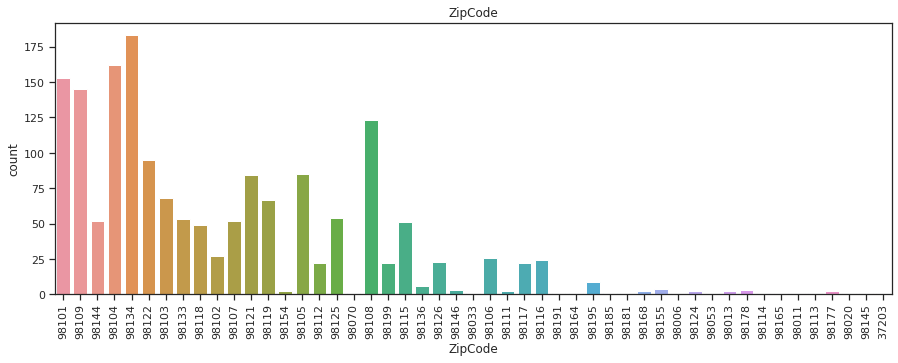

In [840]:
fig, axes = plt.subplots(figsize=(15, 5), sharey=True)

sns.countplot(data.ZipCode)
plt.xticks(rotation=90)
axes.set_title(ZipCode.name)

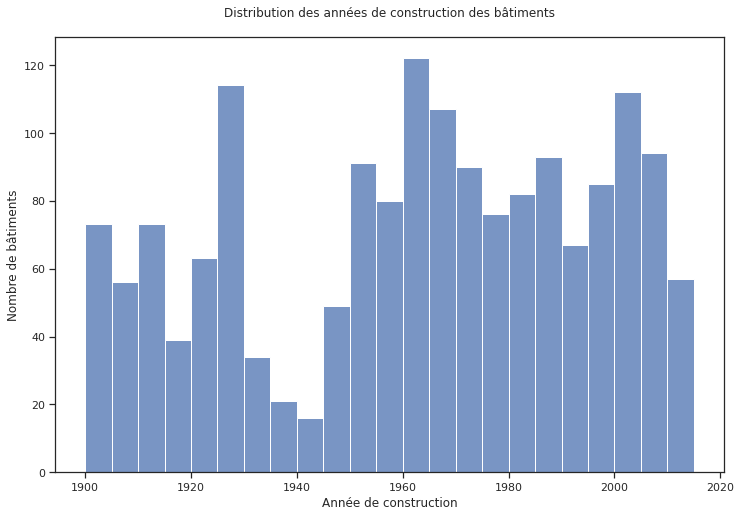

In [841]:
fig = plt.figure(figsize=(12,8))
ax = sns.histplot(data=data, x='YearBuilt', bins=int((data.YearBuilt.max() - data.YearBuilt.min())/5))
ax.set_xlabel("Année de construction")
ax.set_ylabel("Nombre de bâtiments")
plt.title(f"Distribution des années de construction des bâtiments\n")
plt.show()

Plus que l'année de construction, il serait intéressant de traiter l'**âge des bâtiments**. Nous allons donc créer cette nouvelle variable et supprimer l'année de construction :

In [842]:
data.shape

(1694, 41)

(1694, 40)


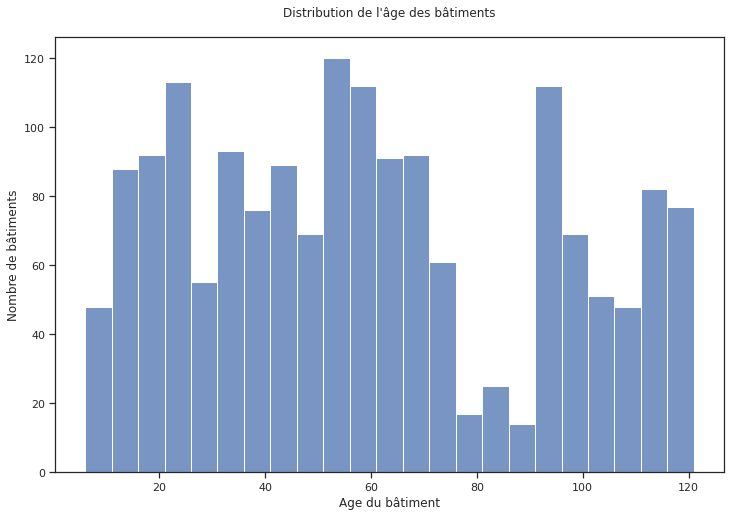

In [843]:
#data['BuildingAge'] = data['DataYear'] - data['YearBuilt']

data.drop('YearBuilt', axis=1, inplace=True)
print(data.shape)

fig = plt.figure(figsize=(12,8))
ax = sns.histplot(data=data, x='Age', bins=int((data.Age.max() - data.Age.min())/5))
ax.set_xlabel("Age du bâtiment")
ax.set_ylabel("Nombre de bâtiments")
plt.title(f"Distribution de l'âge des bâtiments\n")
plt.show()

## <font color="#337da4" id="section_2">Corrélations linéaires</font>

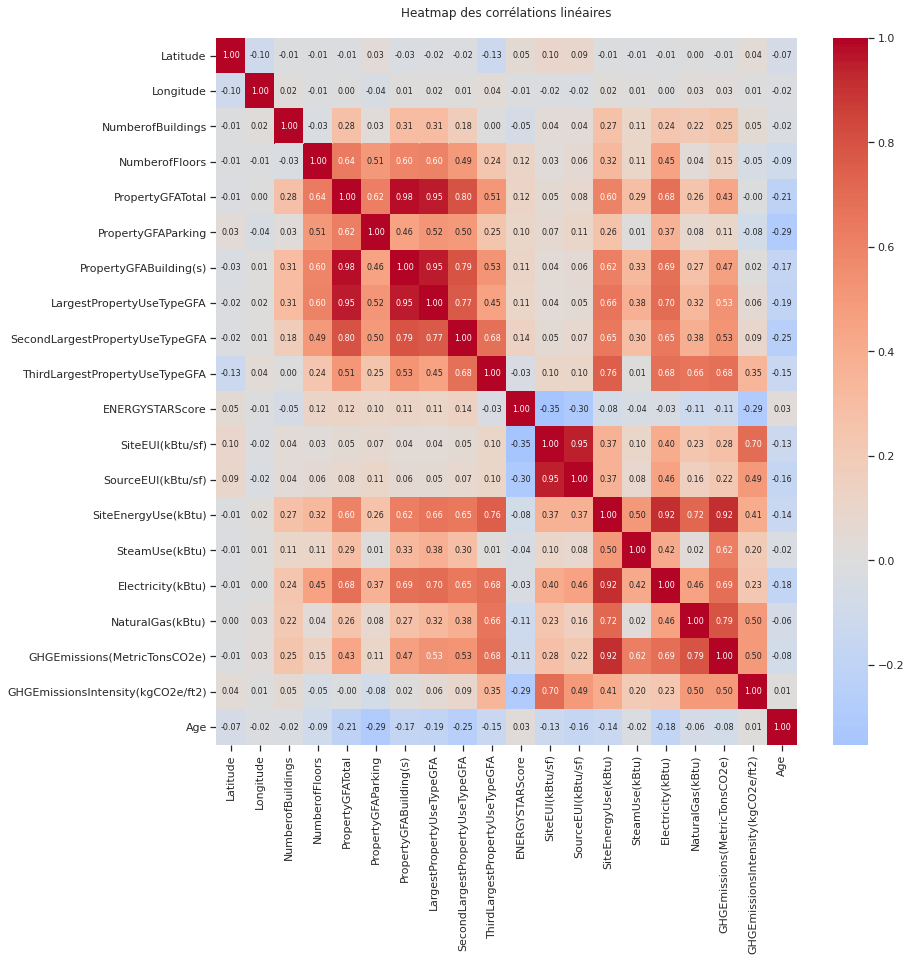

In [844]:
corr = data.corr()
#mask = np.zeros_like(corr)
#mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(13,13))

ax = sns.heatmap(corr, annot=True, fmt=".2f", annot_kws={'size':8},center=0, cmap="coolwarm")
plt.title(f"Heatmap des corrélations linéaires\n")
plt.show()

Pour la variable à prédire `SiteEnergyUse(kBtu)` et `GHGEmissions(MetricTonsCO2e)` , on remarque des corrélations linéaires positive avec 
* le nombre de batiments ou d'étages
* les surfaces au sol
* les variables de relevés de consommations


On remarque également que `GHGEmissions(MetricTonsCO2e)` est corrélée à  r = 0,5 avec elle - même mais sous une autre unité `GHGEmissionsIntensity(kgCO2e/ft2)`, ce qui est relativement faible pour deux variables exprimant une même information.
De plus,  `SiteEnergyUse(kBtu)` est à r =0,92 contre r= 0,41 respectivement pour `GHGEmissions(MetricTonsCO2e)` et `GHGEmissionsIntensity(kgCO2e/ft2)`. 

On remarque sur ce Heatmap de fortes **corrélations linéaires** entre variables. Ces corrélations peuvent amener des problèmes de **colinéarité** (une colonne de la matrice X est une combinaison de deux autres colonnes de la matrice X) dans nos futurs modèles.
Isolons donc les paires de variables avec des corrélations de Pearson supérieurs à  |r| > 0,8: https://eric.univ-lyon2.fr/~ricco/cours/slides/Reg_Multiple_Colinearite_Selection_Variables.pdf



In [845]:
threshold = 0.8

corr_pairs = corr.unstack().sort_values(kind="quicksort")
strong_corr = (pd.DataFrame(corr_pairs[(abs(corr_pairs) > threshold)])
               .reset_index().rename(columns={0:'corr_coeff'}))

strong_corr = strong_corr[(strong_corr.index%2 == 0) & (strong_corr['level_0'] != strong_corr['level_1'])]
strong_corr.sort_values('corr_coeff', ascending=False)

,level_0,level_1,corr_coeff
12,PropertyGFABuilding(s),PropertyGFATotal,0.980212
10,LargestPropertyUseTypeGFA,PropertyGFATotal,0.953973
8,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,0.953262
6,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),0.952275
4,Electricity(kBtu),SiteEnergyUse(kBtu),0.916300
2,SiteEnergyUse(kBtu),GHGEmissions(MetricTonsCO2e),0.916271
0,SecondLargestPropertyUseTypeGFA,PropertyGFATotal,0.801736


`PropertyGFATotal`, `PropertyGFABuilding(s)`, 

`LargestPropertyUseTypeGFA` 	`SecondLargestPropertyUseTypeGFA` présentent de fortes corrélations avec plusieurs variables. Essayons de créer de nouvelles variables pour voir si ces corrélations sont toujours aussi fortes.

In [846]:
# format string to list 
def split_words(df, column = None):
    list_words = set()
    for word in df[column].str.split(','): #list
        if isinstance(word, float): #word , une instance ou une sous-classe de la classe du deuxième argument).de float
            continue
        list_words = set().union(word, list_words) #pour pas de répetition 
        #print(word)
    return list(list_words)

list_use_type = split_words(data, 'ListOfAllPropertyUseTypes')
print("Nombre de type d'usages dans la base : {}".format(len(list_use_type)))

Nombre de type d'usages dans la base : 117


In [847]:
#Nouvelle colonne 
data['NumberofPropertyUseTypes'] = data['ListOfAllPropertyUseTypes'].str.split(',').str.len()
#Suppression colonne
data.drop('ListOfAllPropertyUseTypes', axis=1, inplace=True)
data.shape

(1694, 40)

In [848]:
data.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,YearsENERGYSTARCertified,DefaultData,ComplianceStatus,Outlier,Latitude,Longitude,Address,City,State,ZipCode,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),Age,NumberofPropertyUseTypes
0,325,2015-01-01,NonResidential,Retail Store,WESTLAKE MALL RETAIL PORTION,659000005,7,DOWNTOWN,NaN,NaN,NaN,NaN,No,Compliant,No outlier,47.611711,-122.336816,400 PINE ST,Seattle,WA,98101,1.0,4.0,111077.0,0.0,111077.0,NaN,NaN,NaN,91.0,60.6,190.2,9898724.0,0.0,9899135.0,0.0,69.01,0.24,32,NaN
1,400,2015-01-01,NonResidential,Small- and Mid-Sized Office,GALLAND & SENECA BUILDINGS,1974700175,7,DOWNTOWN,Office,NaN,NaN,NaN,No,Compliant,No outlier,47.606799,-122.337100,1201 2ND AVE,Seattle,WA,98101,1.0,6.0,98370.0,25920.0,72450.0,98370.0,NaN,NaN,45.0,66.3,207.5,6525887.0,0.0,6488262.0,37893.0,47.24,0.20,115,1.0
2,442,2015-01-01,NonResidential,Large Office,KING BROADCASTING,1991200870,7,LAKE UNION,Office,Parking,Other,NaN,No,Compliant,No outlier,47.621476,-122.343050,333 DEXTER AVE N,Seattle,WA,98109,1.0,4.0,193788.0,37854.0,155934.0,138672.0,47539.0,11166.0,59.0,105.8,332.3,16760217.0,0.0,16760914.0,0.0,116.84,0.23,74,5.0
3,499,2015-01-01,NonResidential,Small- and Mid-Sized Office,ASIAN COUNSELING and REFERRAL SERVICE BUILDING,1426300170,2,GREATER DUWAMISH,Office,Parking,NaN,NaN,Yes,Compliant,No outlier,47.570897,-122.297412,3639 MARTIN LUTHER KING JR WAY S,Seattle,WA,98144,1.0,3.0,76598.0,21410.0,55188.0,55188.0,21410.0,NaN,76.0,81.1,169.8,4476997.0,0.0,2234200.0,2242889.0,134.69,1.63,13,2.0
4,559,2015-01-01,NonResidential,Large Office,YALE & THOMAS,6847700105,7,LAKE UNION,Office,Parking,NaN,NaN,No,Compliant,No outlier,47.621243,-122.329786,325 EASTLAKE AVE E,Seattle,WA,98109,1.0,4.0,186971.0,0.0,186971.0,186977.0,115477.0,NaN,86.0,67.7,179.1,12662456.0,0.0,9657951.0,3004906.0,226.92,0.99,40,2.0


In [849]:
#On calcule les ratios
data['GFABuildingRate'] = (round((data['PropertyGFABuilding(s)']
                                  /data['PropertyGFATotal']),5))
data['GFAParkingRate'] = (round((data['PropertyGFAParking']
                                 /data['PropertyGFATotal']),5))
data.shape

(1694, 42)

In [850]:
#On supprime les variables inutiles
data.drop(["LargestPropertyUseType"  ,                 #remplace par PrimaryPropertyType     
           'LargestPropertyUseTypeGFA',                #remplace par PropertyGFATotal  
           'SecondLargestPropertyUseTypeGFA',          #remplace par PropertyGFATotal 
           'SecondLargestPropertyUseType',
           'ThirdLargestPropertyUseTypeGFA',           #remplace par PropertyGFATotal 
           'ThirdLargestPropertyUseType',
           'PropertyGFAParking',      #'GFAParkingRate'
           'PropertyGFABuilding(s)'], #'GFABuildingRate']
         axis=1, inplace=True)
data.shape

(1694, 34)

'''PrimaryPropertyType : The primary **use of a property** (e.g. office, retail store). 
Primary use is defined as a function that accounts for more than 50% of a property. 
This is the Property Type - EPA Calculated field from Portfolio Manager.'''

In [851]:
#surface moyenne par bâtiment  :
data['GFAPerBuilding'] = round((data['PropertyGFATotal'] / data['NumberofBuildings']),3)
#surface moyenne par étage :
data['GFAPerFloor'] = round((data['PropertyGFATotal'] / data['NumberofFloors']),3)
data.shape

(1694, 36)

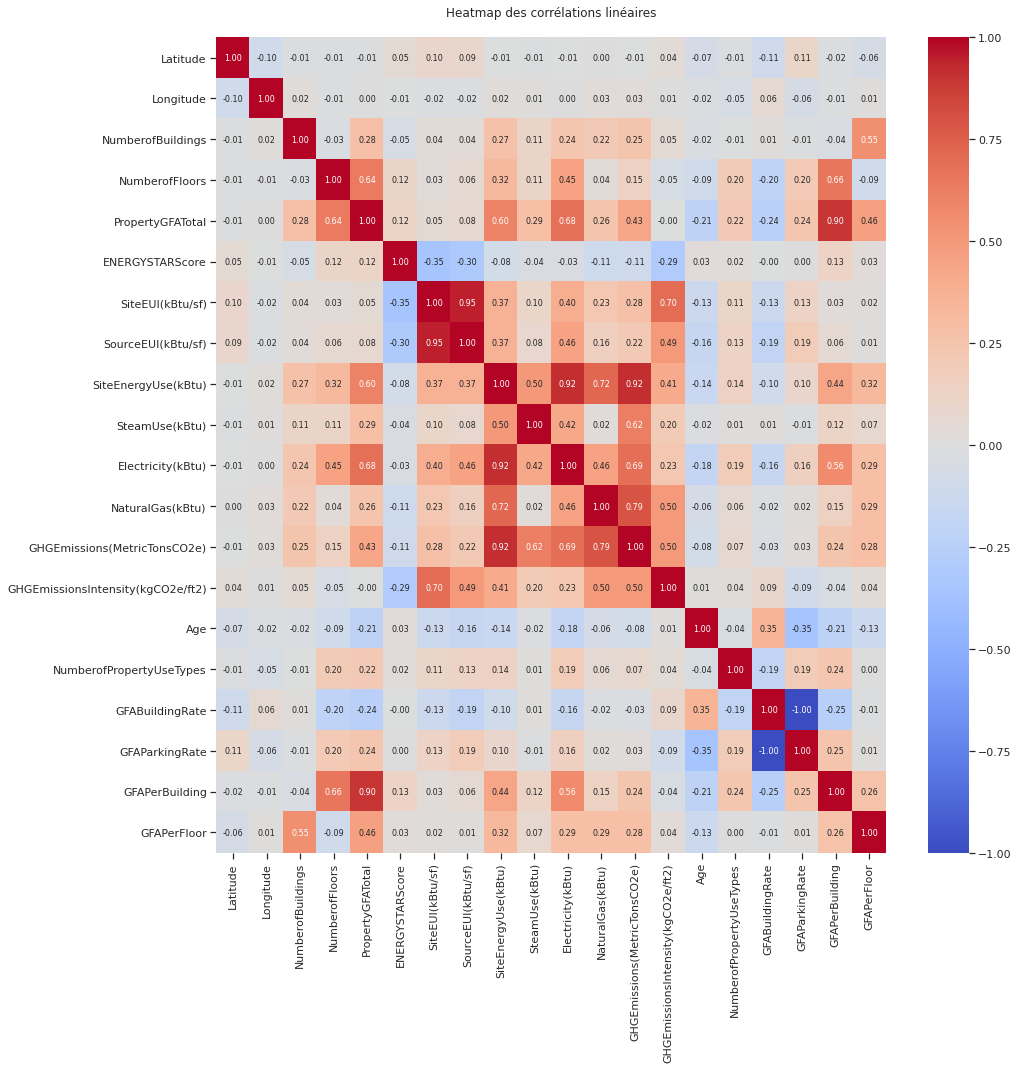

In [852]:
corr = data.corr()

fig, ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(corr, annot=True, fmt=".2f", annot_kws={'size':8}, center=0, cmap="coolwarm")
plt.title(f"Heatmap des corrélations linéaires\n")
plt.show()

In [853]:
threshold = 0.8
corr_pairs = corr.unstack().sort_values(kind="quicksort")
strong_corr = (pd.DataFrame(corr_pairs[(abs(corr_pairs) > threshold)])
               .reset_index().rename(columns={0:'corr_coeff'}))
strong_corr = strong_corr[(strong_corr.index%2 == 0) & (strong_corr['level_0'] != strong_corr['level_1'])]
strong_corr.sort_values('corr_coeff', ascending=False)

,level_0,level_1,corr_coeff
8,SourceEUI(kBtu/sf),SiteEUI(kBtu/sf),0.952275
6,SiteEnergyUse(kBtu),Electricity(kBtu),0.916300
4,SiteEnergyUse(kBtu),GHGEmissions(MetricTonsCO2e),0.916271
2,PropertyGFATotal,GFAPerBuilding,0.896388
0,GFAParkingRate,GFABuildingRate,-1.000000


Nous obtenons déjà moins de pairs de variables corrélées.

In [854]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

strong_corr_features = list(set(list(strong_corr['level_0'].values) + list(strong_corr['level_1'].values)))
X = data[strong_corr_features].replace([np.inf, -np.inf], np.nan)
X = X.dropna()

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                   for i in range(len(X.columns))]
vif_data[vif_data['VIF'] > 10]

,feature,VIF
2,Electricity(kBtu),46.617223
3,SourceEUI(kBtu/sf),16.553640
5,SiteEUI(kBtu/sf),14.427047
7,GHGEmissions(MetricTonsCO2e),43.677134
8,SiteEnergyUse(kBtu),139.259258


In [855]:
#suppression de variable en pied carré comme unité
#SourceEUI(kBtu/sf) et de SiteEUI(kBtu/sf) , GHGEmissionsIntensity(kgCO2e/ft2)
# ramenées à la surface par étage remplace par 'GFAPerFloor'

Eui_features = search_componant(data, suffix='EUI(kBtu/sf)') + ["GHGEmissionsIntensity(kgCO2e/ft2)"]
data.drop(Eui_features, axis=1, inplace=True)
data.shape

(1694, 33)

## <font color="#337da4" id="section_2">Analyse des variables y1 et y2</font>

Les variables à prédire sont : `GHGEmissions(MetricTonsCO2e)`, `SiteEnergyUse(kBtu)`

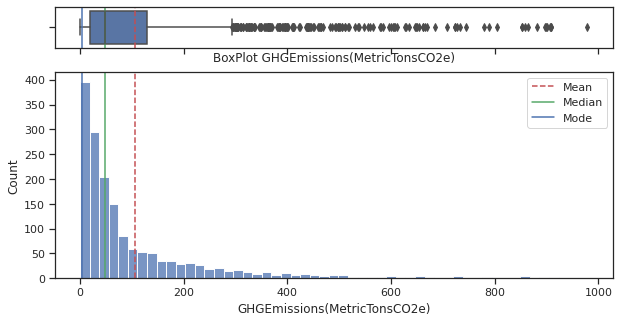

In [856]:
plt.rcParams['figure.figsize'] = (10, 5) 

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)})
zoom = data[data["GHGEmissions(MetricTonsCO2e)"] < 1000 ]
mean=zoom["GHGEmissions(MetricTonsCO2e)"].mean()
median=zoom["GHGEmissions(MetricTonsCO2e)"].median()
mode=zoom.mode()["GHGEmissions(MetricTonsCO2e)"].values[0]

sns.boxplot(data=zoom, x="GHGEmissions(MetricTonsCO2e)", ax=ax_box)
ax_box.axvline(mean, color='r', linestyle='--') 
ax_box.axvline(median, color='g', linestyle='-')
ax_box.axvline(mode, color='b', linestyle='-')

sns.histplot(data=zoom, x="GHGEmissions(MetricTonsCO2e)", ax=ax_hist)
ax_hist.axvline(mean, color='r', linestyle='--', label="Mean")
ax_hist.axvline(median, color='g', linestyle='-', label="Median")
ax_hist.axvline(mode, color='b', linestyle='-', label="Mode")
    
ax_hist.legend()
ax_hist.set(xlabel='GHGEmissions(MetricTonsCO2e)') 
ax_box.set(xlabel='BoxPlot GHGEmissions(MetricTonsCO2e)')
plt.show();

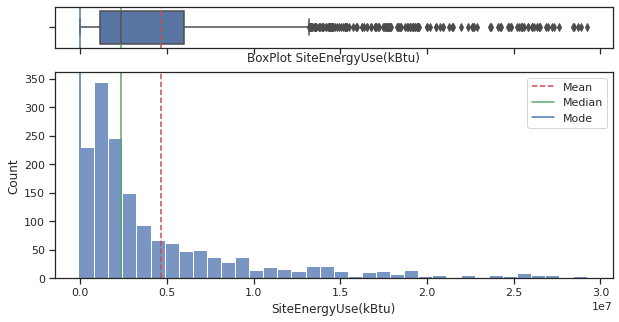

In [857]:
plt.rcParams['figure.figsize'] = (10, 5) 

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)})
zoom = data[(data["SiteEnergyUse(kBtu)"] < 0.3*10**8)  ]
mean=zoom["SiteEnergyUse(kBtu)"].mean()
median=zoom["SiteEnergyUse(kBtu)"].median()
mode=zoom.mode()["SiteEnergyUse(kBtu)"].values[0]

sns.boxplot(data=zoom, x="SiteEnergyUse(kBtu)", ax=ax_box)
ax_box.axvline(mean, color='r', linestyle='--') 
ax_box.axvline(median, color='g', linestyle='-')
ax_box.axvline(mode, color='b', linestyle='-')

sns.histplot(data=zoom, x="SiteEnergyUse(kBtu)", ax=ax_hist)
ax_hist.axvline(mean, color='r', linestyle='--', label="Mean")
ax_hist.axvline(median, color='g', linestyle='-', label="Median")
ax_hist.axvline(mode, color='b', linestyle='-', label="Mode")
    
ax_hist.legend()
ax_hist.set(xlabel='SiteEnergyUse(kBtu)') 
ax_box.set(xlabel='BoxPlot SiteEnergyUse(kBtu)')
plt.show();

In [858]:
data.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),GHGEmissions(MetricTonsCO2e),Age,NumberofPropertyUseTypes,GFABuildingRate,GFAParkingRate,GFAPerBuilding,GFAPerFloor
count,1694.00000,1694.00000,1694.00000,1694.00000,1694.00000,1154.00000,1694.00000,1694.00000,1694.00000,1694.00000,1694.00000,1694.00000,1685.00000,1694.00000,1694.00000,1694.00000,1694.00000
mean,47.61607,-122.33294,1.08412,4.10685,113044.11423,64.97877,7953726.23794,464053.89795,5485837.81912,1975168.74678,178.96372,59.21133,1.89318,0.93732,0.06268,109704.29110,inf
std,0.04807,0.02458,0.88525,6.52306,193111.63195,28.05468,21566493.84474,4947198.84926,13351992.03992,9408883.36833,697.02834,32.82660,1.22007,0.13925,0.13925,187841.22289,nan
min,47.49917,-122.41182,0.50000,0.00000,11285.00000,1.00000,0.00000,0.00000,7.00000,0.00000,0.12000,6.00000,1.00000,-0.25116,-0.00001,7166.66700,221.69700
25%,47.58582,-122.34328,1.00000,1.00000,29383.00000,46.50000,1216914.79688,0.00000,732844.37500,0.00000,20.16500,32.00000,1.00000,1.00000,0.00000,29161.00025,13283.13750
50%,47.61235,-122.33300,1.00000,2.00000,49266.00000,72.50000,2551749.56250,0.00000,1643405.50000,499698.75000,50.26750,56.00000,2.00000,1.00000,0.00000,49289.50000,22982.08350
75%,47.64934,-122.32172,1.00000,4.00000,106589.25000,88.37500,6958824.50000,0.00000,4868752.50000,1510749.87500,139.60500,91.00000,2.00000,1.00000,0.00000,104288.75000,38218.25000
max,47.73387,-122.25864,20.00000,99.00000,2200000.00000,100.00000,448385312.00000,131406600.00000,279629408.50000,297909000.00000,16870.98000,121.00000,13.00000,1.00001,1.25116,2761918.00000,inf


In [859]:
#mode - mediane -  moyenne
data.select_dtypes(include=['float64']).agg([lambda x:x.value_counts().index[0], 'median','mean']).apply(lambda s: s.apply('{0:.5f}'.format))

,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),GHGEmissions(MetricTonsCO2e),NumberofPropertyUseTypes,GFABuildingRate,GFAParkingRate,GFAPerBuilding,GFAPerFloor
<lambda>,47.66246,-122.29898,1.00000,1.00000,21600.00000,100.00000,659455.43750,0.00000,3960888.00000,0.00000,3.73000,1.00000,1.00000,0.00000,25920.00000,inf
median,47.61235,-122.33300,1.00000,2.00000,49266.00000,72.50000,2551749.56250,0.00000,1643405.50000,499698.75000,50.26750,2.00000,1.00000,0.00000,49289.50000,22982.08350
mean,47.61607,-122.33294,1.08412,4.10685,113044.11423,64.97877,7953726.23794,464053.89795,5485837.81912,1975168.74678,178.96372,1.89318,0.93732,0.06268,109704.29110,inf


In [860]:
data.select_dtypes(include=['float64']).agg(['skew','kurtosis'])

,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),GHGEmissions(MetricTonsCO2e),NumberofPropertyUseTypes,GFABuildingRate,GFAParkingRate,GFAPerBuilding,GFAPerFloor
skew,0.233352,-0.066253,13.498257,6.071194,4.983229,-0.756893,10.885515,21.454001,9.251968,21.638782,15.039327,2.298471,-2.54859,2.54859,5.620105,NaN
kurtosis,-0.204406,0.726797,218.960610,53.318321,32.637427,-0.517977,165.621720,523.896951,138.411008,612.637807,289.119775,9.284902,7.65186,7.65186,46.339242,NaN


Skewness\
Si γ1=0 alors la distribution est symétrique.\
Si γ1>0 alors la distribution est étalée à droite.\
Si γ1<0 alors la distribution est étalée à gauche.

kurtosis :\
Si γ2=0 , alors la distribution a le même aplatissement que la distribution normale.\
Si γ2>0, alors elle est moins aplatie que la distribution normale : les observations sont plus concentrées.\
Si γ2<0 , alors les observations sont moins concentrées : la distribution est plus aplatie.

Text(0.5, 1.0, 'SiteEnergyUse(kBtu)')

<Figure size 720x360 with 0 Axes>

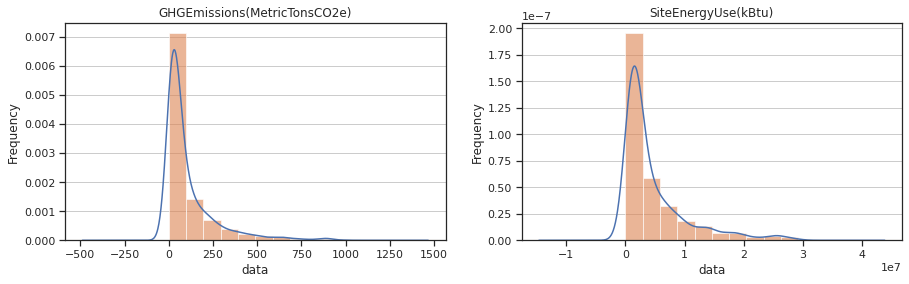

In [861]:
#multiple plot : https://realpython.com/python-histograms/
#subplot multiple plot : https://widdowquinn.github.io/Teaching-Data-Visualisation/exercises/one_variable_continuous/one_variable_continuous.html
# Create figure
fig = plt.figure()
fig = plt.figure(figsize=(15, 4))

# Create subplot axes
ax1 = fig.add_subplot(1, 2, 1)  # 1x3 grid, position 1
ax2 = fig.add_subplot(1, 2, 2)  # 1x3 grid, position 1

zoom = data[data["GHGEmissions(MetricTonsCO2e)"] < 1000 ]
ax1 = zoom["GHGEmissions(MetricTonsCO2e)"].plot.kde(ax=ax1, legend=False, title='Histogram: 2015 vs. 2016 pour GHGEmissions(MetricTonsCO2e)')
ax1 = zoom["GHGEmissions(MetricTonsCO2e)"].plot.hist(density=True,stacked=False,alpha=0.6, ax=ax1)
zoom = data[(data["SiteEnergyUse(kBtu)"] < 0.3*10**8)  ]
ax2 = zoom["SiteEnergyUse(kBtu)"].plot.kde(ax=ax2, legend=False, title='Histogram: 2015 vs. 2016 pour SiteEnergyUse(kBtu)')
ax2 = zoom["SiteEnergyUse(kBtu)"].plot.hist(density=True,stacked=False,alpha=0.6, ax=ax2)

for axis in (ax1, ax2):
    axis.set_xlabel('data')    
for axis in (ax1, ax2):
    axis.grid(axis='y')
ax1.set_title('GHGEmissions(MetricTonsCO2e)')
ax2.set_title('SiteEnergyUse(kBtu)')

In [862]:
from scipy import stats
#Perform the Shapiro-Wilk test for normality.
shapiro_test = stats.shapiro(data["GHGEmissions(MetricTonsCO2e)"] )

shapiro_test

ShapiroResult(statistic=0.1860840916633606, pvalue=0.0)

Pvalue < au niveau de test de 5% on rejette donc l'hypothèse de normalité

In [863]:
#Perform the Shapiro-Wilk test for normality.
shapiro_test = stats.shapiro(data["SiteEnergyUse(kBtu)"] )

shapiro_test

ShapiroResult(statistic=0.2954683303833008, pvalue=0.0)

Pvalue < au niveau de test de 5% on rejette donc l'hypothèse de normalité

In [729]:
#numeric_features = data.select_dtypes(include=['float64', 'int64'])
#numeric_features.corr()

Text(0.5, 0, 'Coeff de corrélation pour GHGEmissions(MetricTonsCO2e) ')

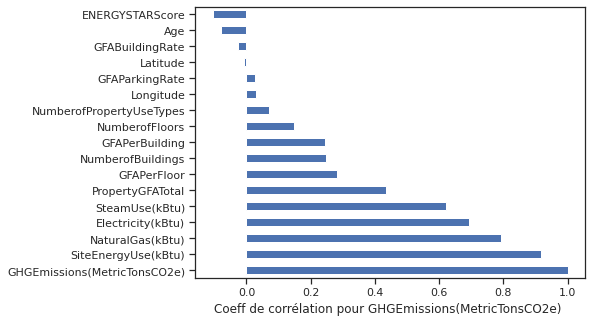

In [864]:
plt.rcParams['figure.figsize'] = (7, 5) 
numeric_features = data.select_dtypes(include=['float64', 'int64'])
corr = numeric_features.corr()
#Variables corrélées à Y = GHGEmissions(MetricTonsCO2e)_y
ax=corr['GHGEmissions(MetricTonsCO2e)'].sort_values(ascending=False).plot(kind="barh")
ax.set_xlabel('Coeff de corrélation pour GHGEmissions(MetricTonsCO2e) ')

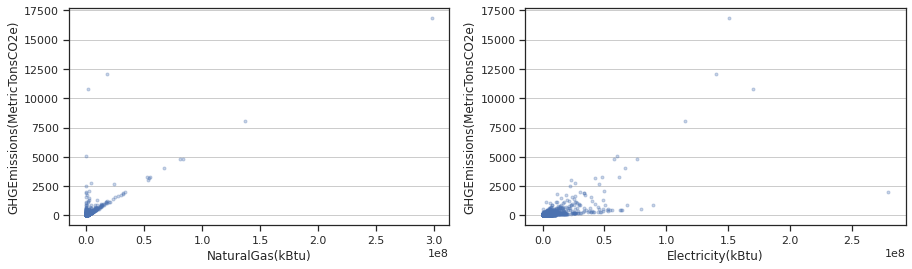

In [865]:
plt.rcParams['figure.figsize'] = (20, 10) #(L,l)
fig = plt.figure(figsize=(15, 4))

# Create subplot axes
ax1 = fig.add_subplot(1, 2, 1)  # 1x3 grid, position 1
ax2 = fig.add_subplot(1, 2, 2)  # 1x3 grid, position 1

# Add scatter plot
ax1.plot(data["NaturalGas(kBtu)"], data["GHGEmissions(MetricTonsCO2e)"],'.', alpha = 0.3)
ax2.plot(data["Electricity(kBtu)"], data["GHGEmissions(MetricTonsCO2e)"],'.', alpha = 0.3)

# Set all axes x-labels
for axes in (ax1,ax2):
    axes.grid(axis='y')

ax1.set_xlabel('NaturalGas(kBtu)')    
ax2.set_xlabel('Electricity(kBtu)')
for axes in (ax1,ax2):
    axes.set_ylabel('GHGEmissions(MetricTonsCO2e)')

In [866]:
#coefficient de dermination R2 ANOVA
coeff_determination = (st.pearsonr(data["NaturalGas(kBtu)"], data["GHGEmissions(MetricTonsCO2e)"])[0])** 2
print(coeff_determination)

0.6256551916825794


In [867]:
coeff_determination = (st.pearsonr(data["Electricity(kBtu)"], data["GHGEmissions(MetricTonsCO2e)"])[0])** 2
coeff_determination 

0.47867102192257993

Text(0.5, 0, 'Coeff de corrélation pour SiteEnergyUse(kBtu) ')

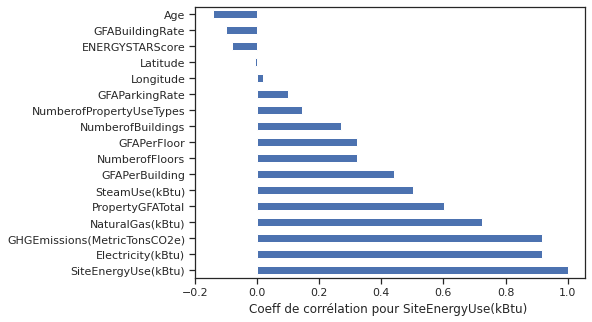

In [868]:
#coefficient de correlation r[-1 ; 1]
plt.rcParams['figure.figsize'] = (7, 5) 
corr = numeric_features.corr()
ax=corr['SiteEnergyUse(kBtu)'].sort_values(ascending=False).plot(kind="barh")
ax.set_xlabel('Coeff de corrélation pour SiteEnergyUse(kBtu) ')

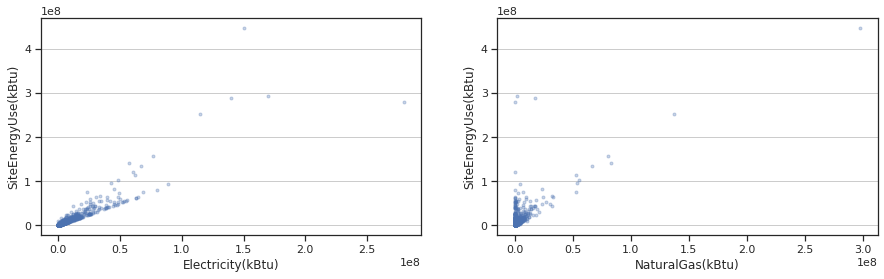

In [869]:
plt.rcParams['figure.figsize'] = (20, 10) #(L,l)
fig = plt.figure(figsize=(15, 4))

# Create subplot axes
ax1 = fig.add_subplot(1, 2, 1)  # 1x3 grid, position 1
ax2 = fig.add_subplot(1, 2, 2)  # 1x3 grid, position 1

# Add scatter plot
ax1.plot(data["Electricity(kBtu)"], data["SiteEnergyUse(kBtu)"],'.', alpha = 0.3)
ax2.plot(data["NaturalGas(kBtu)"], data["SiteEnergyUse(kBtu)"],'.', alpha = 0.3)

  # Set all axes x-labels
for axes in (ax1,ax2):
    axes.grid(axis='y')

ax1.set_xlabel('Electricity(kBtu)')    
ax2.set_xlabel('NaturalGas(kBtu)')
for axes in (ax1,ax2):
    axes.set_ylabel('SiteEnergyUse(kBtu)')

In [870]:
#coefficient de dtermination R2 ANOVA
coeff_determination = (st.pearsonr(data["Electricity(kBtu)"], data["SiteEnergyUse(kBtu)"])[0])** 2
coeff_determination #[0,1]

0.8396060890882541

In [871]:
coeff_determination = (st.pearsonr(data["NaturalGas(kBtu)"], data["SiteEnergyUse(kBtu)"])[0])** 2
coeff_determination #[0,1]

0.523670328833856

Scatter entre les deux variables à prédire.

Text(0, 0.5, 'SiteEnergyUse(kBtu)')

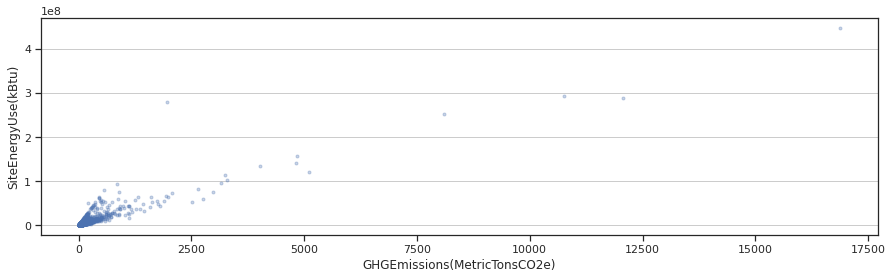

In [872]:
plt.rcParams['figure.figsize'] = (20, 10) #(L,l)
fig = plt.figure(figsize=(15, 4))

# Create subplot axes
ax1 = fig.add_subplot(1, 1, 1)  # 1x3 grid, position 1


# Add scatter plot
ax1.plot(data["GHGEmissions(MetricTonsCO2e)"], data["SiteEnergyUse(kBtu)"],'.', alpha = 0.3)

ax1.grid(axis='y')

ax1.set_xlabel('GHGEmissions(MetricTonsCO2e)')    
ax1.set_ylabel('SiteEnergyUse(kBtu)')

In [873]:
#coefficient de dtermination R2 ANOVA
coeff_determination = (st.pearsonr(data["GHGEmissions(MetricTonsCO2e)"], data["SiteEnergyUse(kBtu)"])[0])** 2
coeff_determination #[0,1]

0.8395521485460568

Le modèle de régression linéaire entre les deux variables Y explique 83,9 % de la variation entre les valeurs prédites et les valeurs réelles.

Pour éviter les corrélations fortes entre Latitude et Longitude, on calcul la distance Harversine entre chaque point de coordonnées et le centre de Seattle, "harvesine_distance". Et on vérifie son impact sur les deux variables à prédire.

In [874]:
from math import radians, cos, sin, asin, sqrt

#Coordonnées du centre de Seattle
seattle_lat = 47.6062
seattle_lon = -122.3321

def haversine_distance(lat1, lng1, lat2, lng2, degrees=True):
    r = 3956 # rayon de la Terre en miles
    
    if degrees:
        lat1, lng1, lat2, lng2 = map(radians, [lat1, lng1, lat2, lng2])
    
    # Formule Haversine
    dlng = lng2 - lng1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlng/2)**2
    d = 2 * r * asin(sqrt(a))  

    return d

In [875]:
#Calcul de la variable harvesine_distance
#Calcul des distance au centre de Seattle pour chaque point
data['harvesine_distance'] = [haversine_distance(seattle_lat, seattle_lon, x, y) 
                              for x, y in zip(data.Latitude.astype(float), data.Longitude.astype(float))]


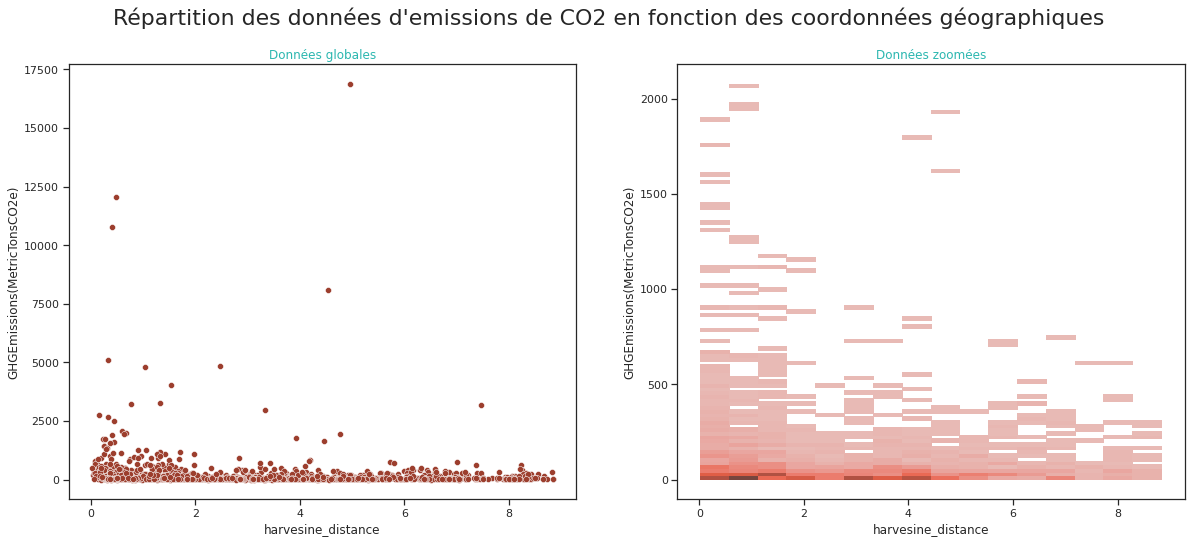

In [876]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))

#plot1
sns.scatterplot(data=data, y="GHGEmissions(MetricTonsCO2e)", x="harvesine_distance", color="#9C3E2D", ax=axes[0])
axes[0].set_title("Données globales", color='#2cb7b0')
#plot2
sns.histplot(data=data[(data['GHGEmissions(MetricTonsCO2e)'] < 2500)], y="GHGEmissions(MetricTonsCO2e)",x="harvesine_distance", color="#9C3E2D", ax=axes[1])
axes[1].set_title("Données zoomées", color='#2cb7b0')

plt.suptitle("Répartition des données d'emissions de CO2 en fonction des coordonnées géographiques",fontsize=22)
plt.show()

In [877]:
data.shape

(1694, 34)

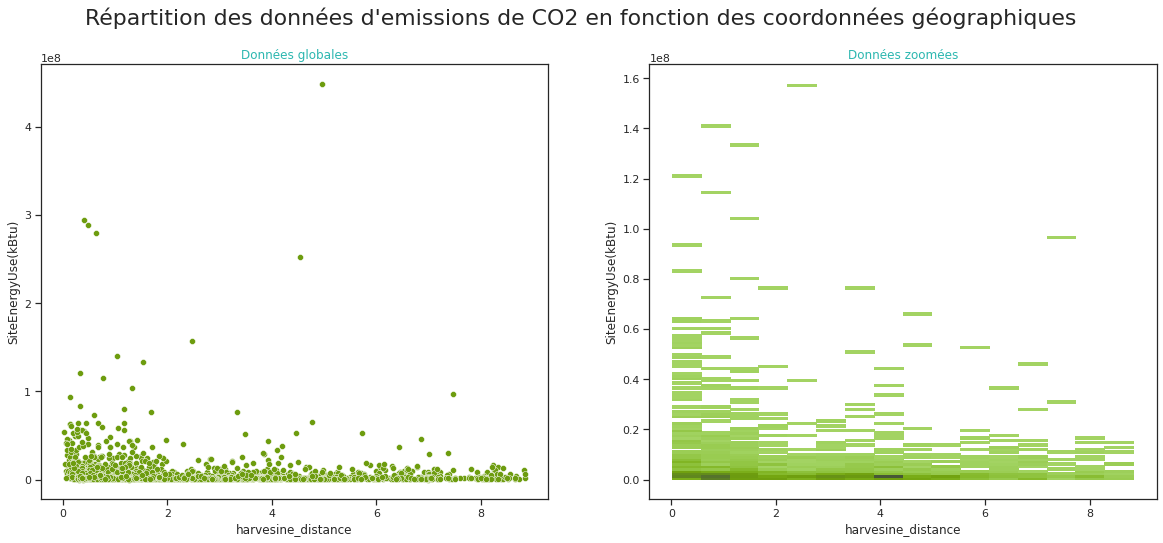

In [878]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))

#plot1
sns.scatterplot(data=data, y="SiteEnergyUse(kBtu)", x="harvesine_distance", color="#6D9C0E", ax=axes[0])
axes[0].set_title("Données globales", color='#2cb7b0')
#plot2
sns.histplot(data=data[(data['SiteEnergyUse(kBtu)'] < 2*10**8)], y="SiteEnergyUse(kBtu)", x="harvesine_distance", color="#6D9C0E", ax=axes[1])
axes[1].set_title("Données zoomées", color='#2cb7b0')

plt.suptitle("Répartition des données d'emissions de CO2 en fonction des coordonnées géographiques",  fontsize=22)
plt.show()

Les coordonnées géographiques (donc les adresses des bâtiments) ont  un impact sur les consommations d'égergie et rejets de CO2 comme le montre les graphiques ci-dessus. 
Nous supprimons les variables latitude et longitude pour éviter la redondance des colonnes.

In [879]:
data = data.drop(['Latitude','Longitude'], axis=1)
data.shape

(1694, 32)

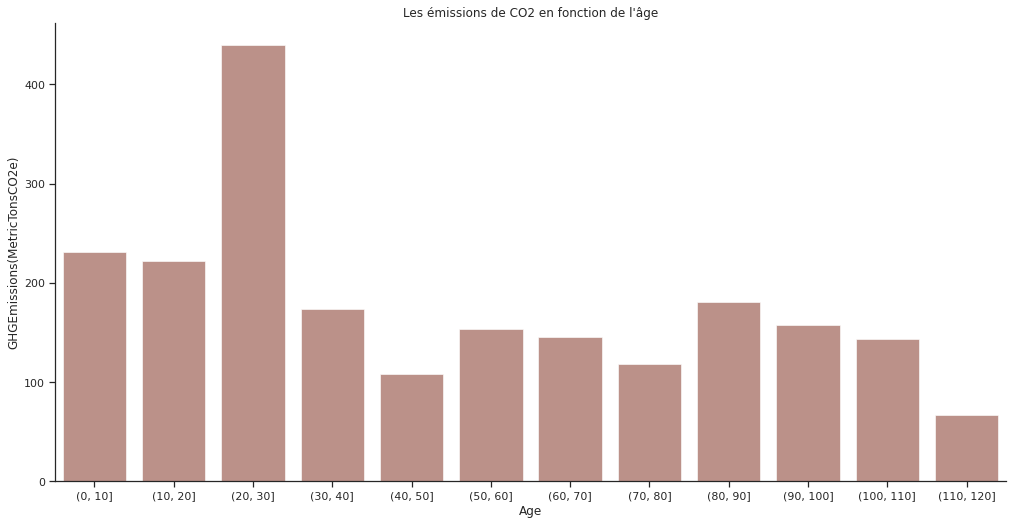

In [880]:
bins = pd.IntervalIndex.from_tuples([(0, 10), (10, 20), (20, 30), (30, 40), (40, 50), 
                                     (50, 60), (60, 70), (70,80), (80,90), (90,100), 
                                     (100,110), (110,120)])

sns.catplot(
    data=data, kind="bar",
    x=pd.cut(data['Age'], bins=bins), y="GHGEmissions(MetricTonsCO2e)", ci=None, color="#9C3E2D", alpha=.6,
    height=7, aspect=2
)
plt.title("Les émissions de CO2 en fonction de l'âge")
plt.show()

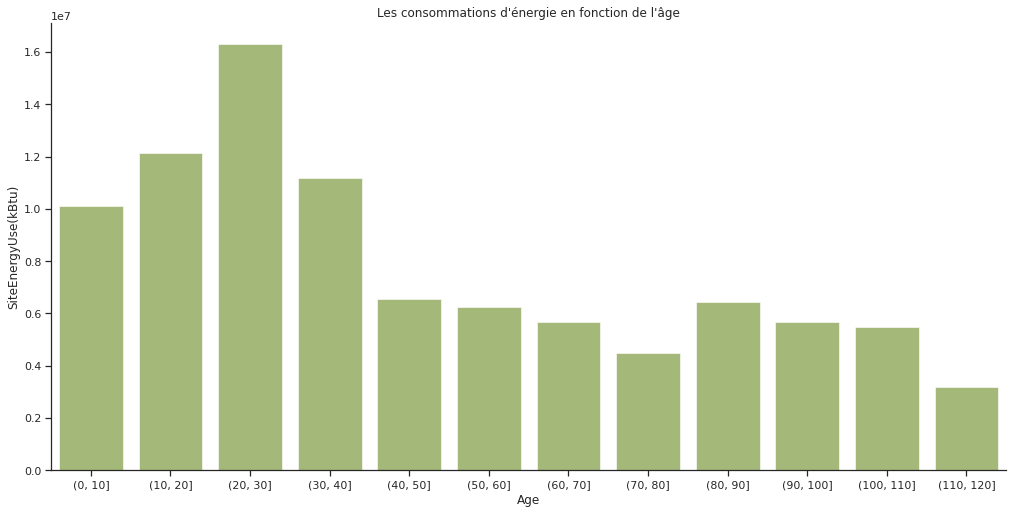

In [881]:
sns.catplot(
    data=data, kind="bar",
    x=pd.cut(data['Age'], bins=bins), y="SiteEnergyUse(kBtu)",
    ci=None, color="#6D9C0E", alpha=.6,
    height=7, aspect=2
)
plt.title("Les consommations d'énergie en fonction de l'âge")
plt.show()



La trance 20 - 30 ans ont un impact plus important que les buildings anciens, alors même que la variable `Age` n'est pas fortement corrélée à d'autres features hormis GFABuildingRate.

## <font color="#337da4" id="section_2">Variables numériques & catégoriques</font>


Text(0, 0.5, 'median')

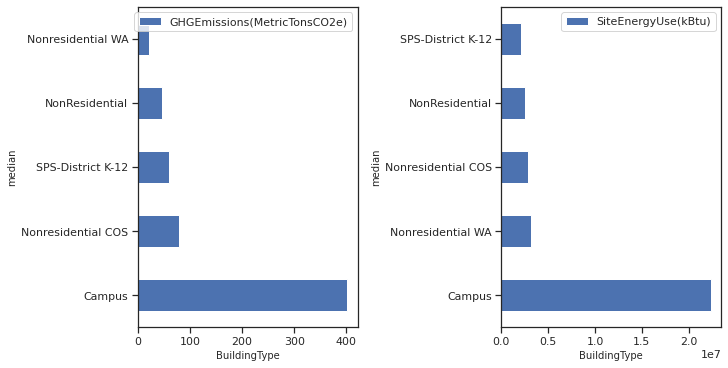

In [882]:
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
plt.rcParams["figure.figsize"] = (10,5)

figure, axes = plt.subplots(1,2, constrained_layout=True)

#BuildingType
BuildingType_pivot = \
data.pivot_table(index='BuildingType',  values="GHGEmissions(MetricTonsCO2e)",aggfunc=np.median)
ax1 = BuildingType_pivot.sort_values(ascending=False, by = "GHGEmissions(MetricTonsCO2e)").plot(ax=axes[0],kind='barh')
ax1.set_xlabel("BuildingType", size = 10)
ax1.set_ylabel("median", size = 10)
#ax1.set_title("Impact of BuildingType on GHGEmissions(MetricTonsCO2e)")

#BuildingType
BuildingType_pivot = \
data.pivot_table(index='BuildingType',  values="SiteEnergyUse(kBtu)",aggfunc=np.median)
ax2 = BuildingType_pivot.sort_values(ascending=False, by = "SiteEnergyUse(kBtu)").plot(ax=axes[1],kind='barh')
ax2.set_xlabel("BuildingType", size = 10)
ax2.set_ylabel("median", size = 10)
#ax1.set_title("Impact of BuildingType on GHGEmissions(MetricTonsCO2e)")



Text(0, 0.5, 'median')

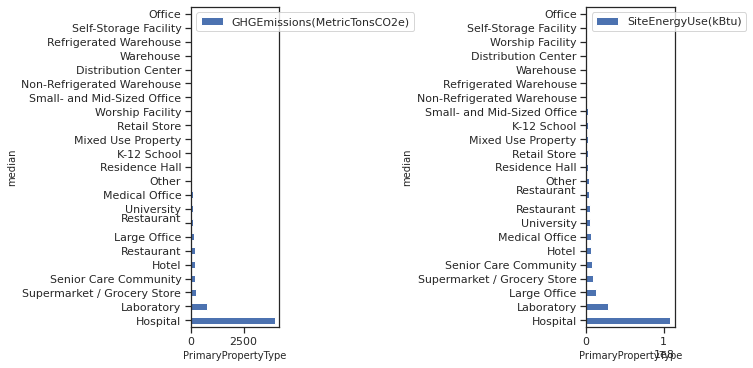

In [883]:
#plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
plt.rcParams["figure.figsize"] = (10,5)


figure, axes = plt.subplots(1,2, constrained_layout=True)

#PrimaryPropertyType
PrimaryPropertyType_pivot = \
data.pivot_table(index='PrimaryPropertyType', values="GHGEmissions(MetricTonsCO2e)", aggfunc=np.median)
ax1= PrimaryPropertyType_pivot.sort_values(ascending=False, by = "GHGEmissions(MetricTonsCO2e)").plot(ax=axes[0],kind='barh')
ax1.set_xlabel("PrimaryPropertyType", size = 10)
ax1.set_ylabel("median", size = 10)
#ax2.set_title("Impact of PrimaryPropertyType on GHGEmissions(MetricTonsCO2e)")

#PrimaryPropertyType
PrimaryPropertyType_pivot = \
data.pivot_table(index='PrimaryPropertyType', values="SiteEnergyUse(kBtu)", aggfunc=np.median)
ax2= PrimaryPropertyType_pivot.sort_values(ascending=False, by = "SiteEnergyUse(kBtu)").plot(ax=axes[1],kind='barh')
ax2.set_xlabel("PrimaryPropertyType", size = 10)
ax2.set_ylabel("median", size = 10)
#ax2.set_title("Impact of PrimaryPropertyType on GHGEmissions(MetricTonsCO2e)")


Les **campus** se démarquent largement en terme de consommation et de rejets de CO2 en valeur mediane. De même pour les **hôpitaux et les laboratoires**. Regardons l'impact de l'âge des bâtiments  sur les variables à prédire :

In [884]:
#Evaluation de la corrélation
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

In [885]:
#Corrélation ANOVA 
Y = "GHGEmissions(MetricTonsCO2e)" 
liste_colonnes = ["BuildingType", "PrimaryPropertyType" ]
result = []
for col in liste_colonnes :
    result.append(eta_squared(data[col],data[Y]))
    
result

[0.06072315298870201, 0.30176850465472166]

In [886]:
##Corrélation ANOVA 
Y = "SiteEnergyUse(kBtu)" 
liste_colonnes = ["BuildingType", "PrimaryPropertyType" ]
result = []
for col in liste_colonnes :
    result.append(eta_squared(data[col],data[Y]))
    
result

[0.06295019418583973, 0.2774281737366571]

Les variables catégoriques `BuildingType` et `PrimaryPropertyType` sont faiblement corrélés aux variables à prédire.

In [887]:
data.to_csv("2015_2016_building_energy_benchmarking_avt_modelisation",sep =",",index=False)
print(data.shape)

(1694, 32)


# <font color="#1d479b" id="section_1">Nettoyage avant modelisation</font>

In [915]:
data = pd.read_csv("2015_2016_building_energy_benchmarking_avt_modelisation",sep ="," ) 
data.shape

(1694, 32)

Supprimer les relevés couteux pour les années à venir.
Nous allons donc exclure toutes les données de relève de notre dataset:
`SteamUse(kBtu)` `Electricity(kBtu)`, `NaturalGas(kBtu)`.

In [916]:
#Suppression des colonnes non utiles

data = data.drop(['DefaultData','ComplianceStatus', 'City',
                  'TaxParcelIdentificationNumber','CouncilDistrictCode', "Outlier",
                 "Address", "ZipCode","SteamUse(kBtu)","Electricity(kBtu)",
                "PropertyName","State", "NaturalGas(kBtu)",'YearsENERGYSTARCertified'], axis=1)
data.shape

(1694, 18)

In [917]:
completude_cols = (data.notna().mean() *100 ).sort_values(ascending = False)
completude_cols

harvesine_distance              100.000000
GFAPerFloor                     100.000000
DataYear                        100.000000
BuildingType                    100.000000
PrimaryPropertyType             100.000000
Neighborhood                    100.000000
NumberofBuildings               100.000000
NumberofFloors                  100.000000
PropertyGFATotal                100.000000
OSEBuildingID                   100.000000
SiteEnergyUse(kBtu)             100.000000
GHGEmissions(MetricTonsCO2e)    100.000000
Age                             100.000000
GFABuildingRate                 100.000000
GFAParkingRate                  100.000000
GFAPerBuilding                  100.000000
NumberofPropertyUseTypes         99.468713
ENERGYSTARScore                  68.122786
dtype: float64

<AxesSubplot:>

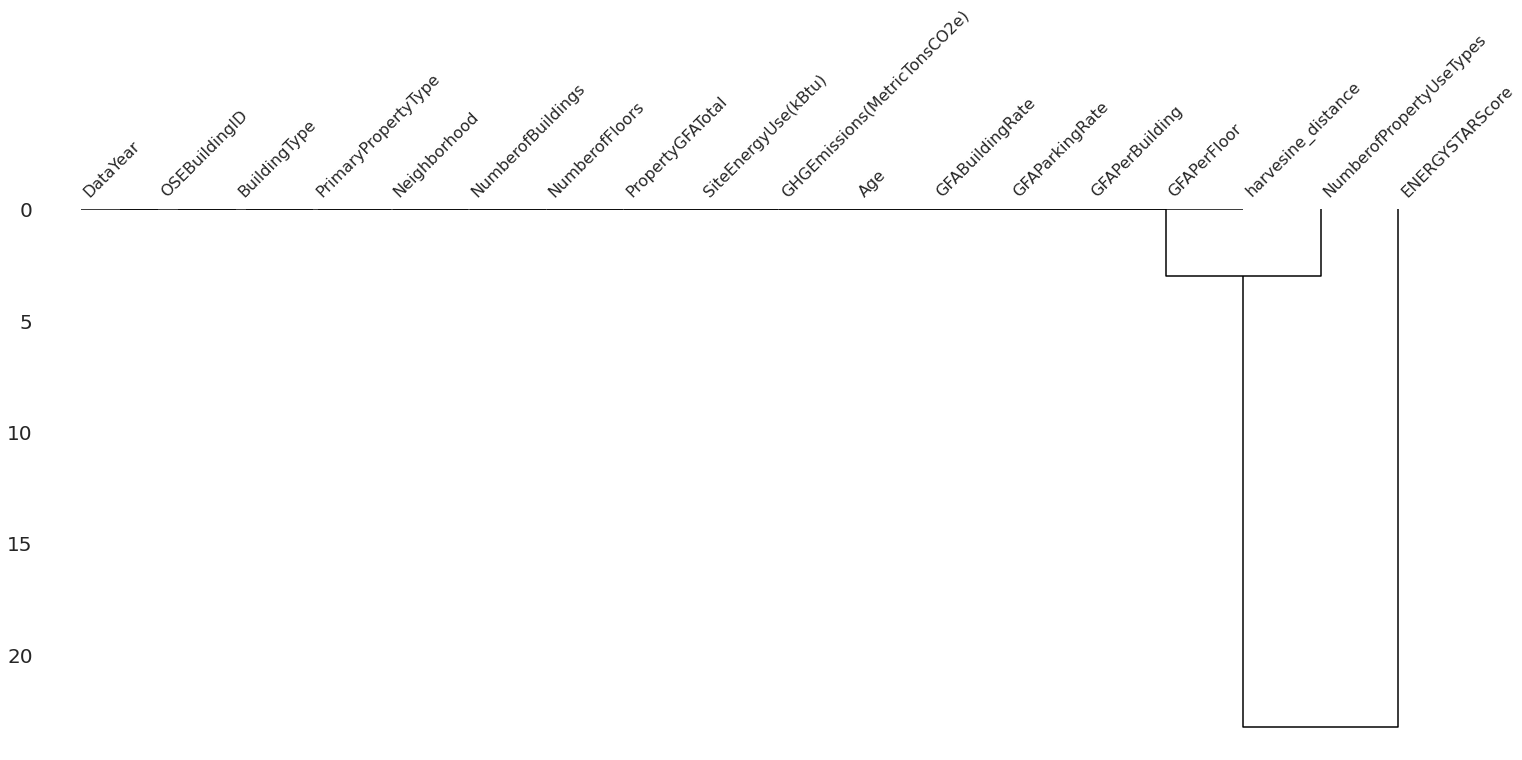

In [893]:
msno.dendrogram(data)

Nous allons tester les différentes méthodes d'imputation et voir si elles conservent la distribution des variables à imputer.

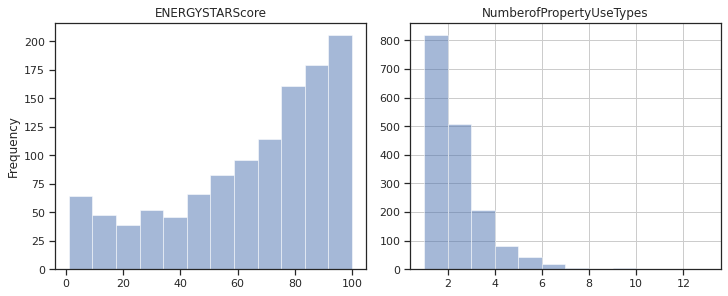

<Figure size 720x288 with 0 Axes>

In [920]:
# Avant Imputation des NaN
plt.rcParams['figure.figsize'] = (10,4) #(L,l)
figure, axes = plt.subplots(1, 2, constrained_layout=True)

ax1 = data["ENERGYSTARScore"].plot.hist(ax=axes[0],alpha=0.5, bins=12)
ax1.set_title("ENERGYSTARScore")
ax2 = data["NumberofPropertyUseTypes"].hist(ax=axes[1],alpha=0.5, bins=12)
ax2.set_title("NumberofPropertyUseTypes")

plt.figure();

In [921]:
data.to_csv("2015_2016_building_energy_benchmarking_to_impute",sep =",",index=False)
print(data.shape)

(1694, 18)


<AxesSubplot:>

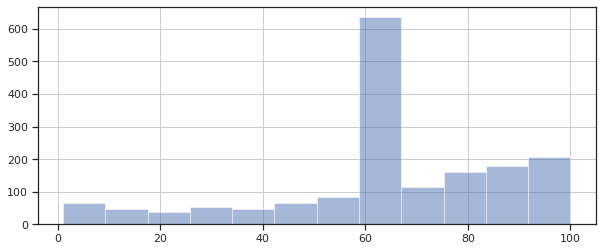

In [922]:
# test avec IterativeImputer
df2 = pd.read_csv("2015_2016_building_energy_benchmarking_to_impute",sep ="," ) 

columns = ['ENERGYSTARScore','NumberofPropertyUseTypes']


from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

df_num = df2.loc[:,columns]
                                      
imputer = IterativeImputer(max_iter=90 ,random_state=0)  
df_num = pd.DataFrame(imputer.fit_transform(df_num),columns=list(df_num.columns)) # df_num pour concat avec les dummies apres

df_num.ENERGYSTARScore.hist(alpha=0.5, bins=12) #iterative imputer

<AxesSubplot:>

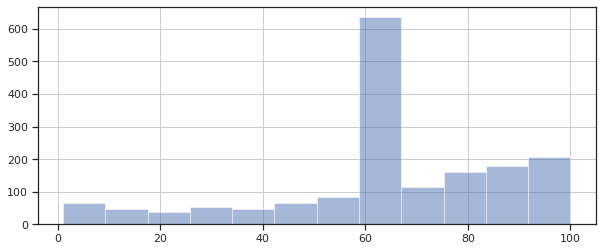

In [923]:
from sklearn.impute import SimpleImputer
df2 = pd.read_csv("2015_2016_building_energy_benchmarking_to_impute",sep ="," ) 

#Test colonne où NaN remplacée par la moyenne

imputer = SimpleImputer(missing_values= np.nan, strategy="mean") 

df2[["ENERGYSTARScore"]] = pd.DataFrame(imputer.fit_transform(df2[["ENERGYSTARScore"]]), columns=['ENERGYSTARScore_y'])

df2.ENERGYSTARScore.hist(alpha=0.5, bins=12) #SimpleImputer mean

(1694, 18)
(1149, 18)


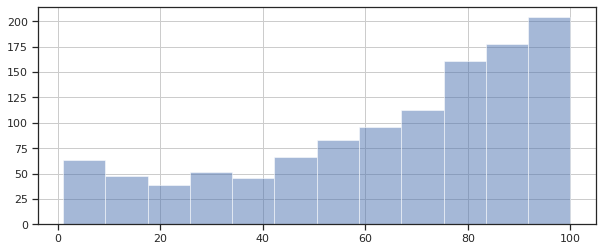

In [924]:
#test suppression des NaN
df2 = pd.read_csv("2015_2016_building_energy_benchmarking_to_impute",sep ="," ) 
print(df2.shape)
df2 = df2.dropna()
df2.ENERGYSTARScore.hist(alpha=0.5, bins=12)
print(df2.shape) # trop de lignes supprimees

(1694, 18)
(1694, 18)


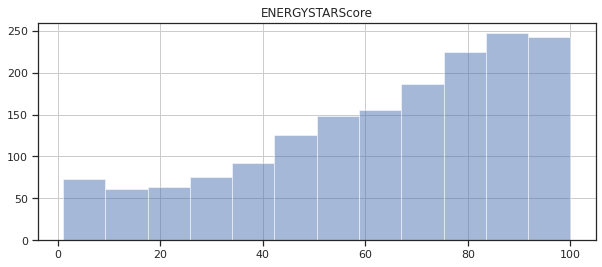

In [929]:
#test avec KNN imputer
df2 = pd.read_csv("2015_2016_building_energy_benchmarking_to_impute",sep ="," ) 
print(df2.shape)

columns = ['NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'ENERGYSTARScore',
 'SiteEnergyUse(kBtu)',
 'GHGEmissions(MetricTonsCO2e)',
 'Age',
 'NumberofPropertyUseTypes',
 'harvesine_distance']
df_num = df2.loc[:,columns]


from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2)                                      
df_num = pd.DataFrame(imputer.fit_transform(df_num),columns=list(df_num.columns)) # df_num pour concat avec les dummies apres


#Remplacement des colonnes
#df2.reset_index(drop=True, inplace=True)
df2.loc[df2.index.isin(df_num.index), ['NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'ENERGYSTARScore',
 'SiteEnergyUse(kBtu)',
 'GHGEmissions(MetricTonsCO2e)',
 'Age',
 'NumberofPropertyUseTypes',
 'harvesine_distance']] = df_num[['NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'ENERGYSTARScore',
 'SiteEnergyUse(kBtu)',
 'GHGEmissions(MetricTonsCO2e)',
 'Age',
 'NumberofPropertyUseTypes',
 'harvesine_distance']]
print(df2.shape)
ax = df2.ENERGYSTARScore.hist(alpha=0.5, bins=12) #OK !
ax.set_title("ENERGYSTARScore")
plt.show()

<AxesSubplot:>

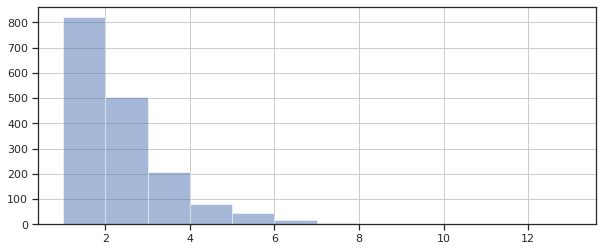

In [926]:
#Avant Imputation
df2 = pd.read_csv("2015_2016_building_energy_benchmarking_to_impute",sep ="," ) 
df2.NumberofPropertyUseTypes.hist(alpha=0.5, bins=12)

<AxesSubplot:>

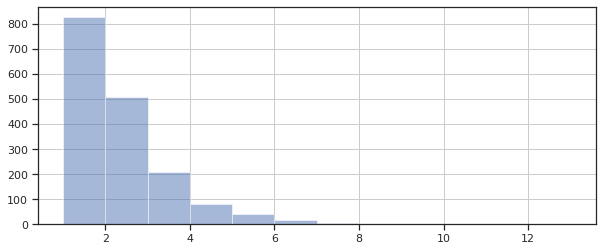

In [930]:
#Apres Imputation
df2.NumberofPropertyUseTypes.hist(alpha=0.5, bins=12)

In [931]:
df2.isna().sum()

OSEBuildingID                   0
DataYear                        0
BuildingType                    0
PrimaryPropertyType             0
Neighborhood                    0
NumberofBuildings               0
NumberofFloors                  0
PropertyGFATotal                0
ENERGYSTARScore                 0
SiteEnergyUse(kBtu)             0
GHGEmissions(MetricTonsCO2e)    0
Age                             0
NumberofPropertyUseTypes        0
GFABuildingRate                 0
GFAParkingRate                  0
GFAPerBuilding                  0
GFAPerFloor                     0
harvesine_distance              0
dtype: int64

Donc le methode d'imputation permettant de garder la distribution est la méthode KNN. 

<AxesSubplot:>

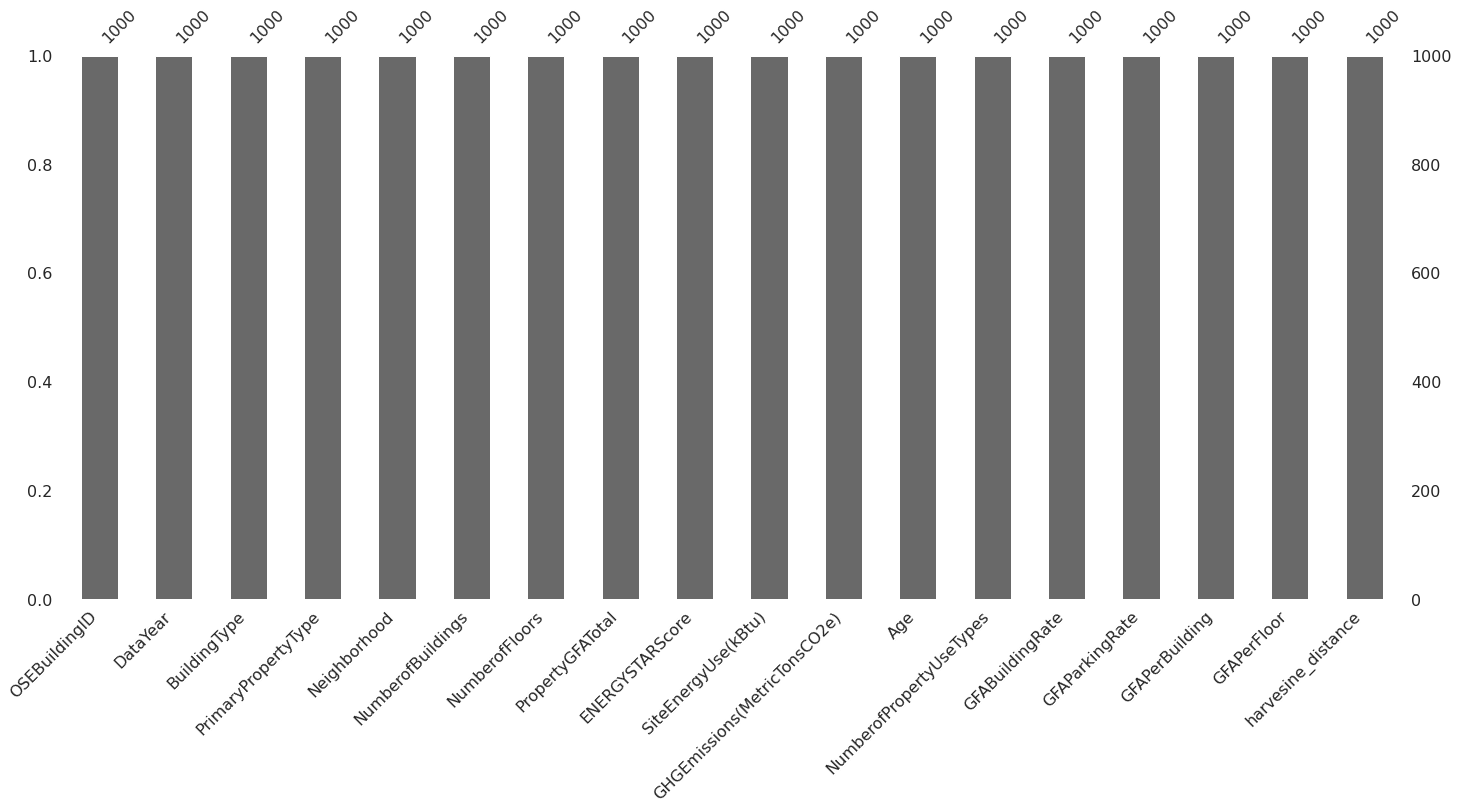

In [932]:
msno.bar(df2.sample(1000))

In [933]:
df2.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEnergyUse(kBtu),GHGEmissions(MetricTonsCO2e),Age,NumberofPropertyUseTypes,GFABuildingRate,GFAParkingRate,GFAPerBuilding,GFAPerFloor,harvesine_distance
0,325,2015-01-01,NonResidential,Retail Store,DOWNTOWN,1.0,4.0,111077.0,91.0,9898724.0,69.01,32.0,1.5,1.00000,0.00000,111077.0,27769.250,0.439292
1,400,2015-01-01,NonResidential,Small- and Mid-Sized Office,DOWNTOWN,1.0,6.0,98370.0,45.0,6525887.0,47.24,115.0,1.0,0.73651,0.26349,98370.0,16395.000,0.236408
2,442,2015-01-01,NonResidential,Large Office,LAKE UNION,1.0,4.0,193788.0,59.0,16760217.0,116.84,74.0,5.0,0.80466,0.19534,193788.0,48447.000,1.171413
3,499,2015-01-01,NonResidential,Small- and Mid-Sized Office,GREATER DUWAMISH,1.0,3.0,76598.0,76.0,4476997.0,134.69,13.0,2.0,0.72049,0.27951,76598.0,25532.667,2.924194
4,559,2015-01-01,NonResidential,Large Office,LAKE UNION,1.0,4.0,186971.0,86.0,12662456.0,226.92,40.0,2.0,1.00000,0.00000,186971.0,46742.750,1.044201


In [911]:
#df2["OSEBuildingID"] = df2["OSEBuildingID"].astype('object')
#numerical_features = df2.select_dtypes(include=['int64','float64'])
#numerical_features.head()

,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEnergyUse(kBtu),GHGEmissions(MetricTonsCO2e),Age,NumberofPropertyUseTypes,GFABuildingRate,GFAParkingRate,GFAPerBuilding,GFAPerFloor,harvesine_distance
0,1.0,4.0,111077.0,91.0,9898724.0,69.01,32.0,1.5,1.00000,0.00000,111077.0,27769.250,0.439292
1,1.0,6.0,98370.0,45.0,6525887.0,47.24,115.0,1.0,0.73651,0.26349,98370.0,16395.000,0.236408
2,1.0,4.0,193788.0,59.0,16760217.0,116.84,74.0,5.0,0.80466,0.19534,193788.0,48447.000,1.171413
3,1.0,3.0,76598.0,76.0,4476997.0,134.69,13.0,2.0,0.72049,0.27951,76598.0,25532.667,2.924194
4,1.0,4.0,186971.0,86.0,12662456.0,226.92,40.0,2.0,1.00000,0.00000,186971.0,46742.750,1.044201


In [913]:
#numerical_features = df2.select_dtypes(include=['int64','float64'])
#Q1 = numerical_features.quantile(0.25)
#Q3 = numerical_features.quantile(0.75)
#IQR = Q3 - Q1
##print(IQR)
## Suppression des outliers extêmes 
#data = df2[~((df2 < (Q1 - 1.5 * IQR)) |(df2 > (Q3 + 1.5 * IQR))).any(axis=1)]
#data.shape

(974, 18)

Il est préférable de ne pas faire la méthode Interquartie car cela supprime trop de donneés.

In [934]:
df2.to_csv("2015_2016_building_energy_benchmarking_cleaned",sep =",",index=False)
print(df2.shape)

(1694, 18)
